# Final Project Submission
* Student name: `Reno Vieira Neto`
* Student pace: `self paced`
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:

# Table of Contents <a class="anchor" id="toc"></a>
**[Business Case and Goals](#bc)**

**[The Dataset](#td)**

**[Dataset Exploration and Cleaning](#dec)**
* [Min and Max Values of Features](#minmax)
* [Scatter Matrix](#sc)
* [Correlation Matrix](#cm)
* [Histogram of Features](#hist)


**[Questions](#q)**
* [When were houses built? Is the Number of New Houses growing over time?](#q1)
* [What's the impact of `date` in `price`? Have prices changed over time?](#q2)
* [What's the importance of Zipcode and Coordinates in `price`?](#q3)
* [Is the dataset evenly distributed in terms of houses by Zip Code?](#q4)
* [What's the Average Sold Price by Zip Code?](#q5)
* [What's the Total Sold by Zip Code?](#q6)
* [Would the distance from Downtown Seattle be a good proxy for coordinates and Zip Code?](#coord_proxy)


**[Run different simulations to estimate Revenue](#rev)**
1. [Define Average Success Rate by Agent](#rev_1)
2. [Remove Outliers](#rev_2)
3. [Define the Housing Market Size](#rev_3)
4. [Estimate Revenue](#rev_4)
5. [Impact of No. of Agents in Net Income in Top 5 Most Profitable Zip Codes](#rev_5)
6. [Analyze results in different scenarios](#rev_6)
7. [Conclusion](#rev_7)
    
    
**[Modeling](#mol)**

* **[Feature Transformation](#transf)**
    * [Null Values and Boolean Fields](#transf_1)
    * [Create new features/feature engineering](#transf_2)
    * [Reduce bias in model towards Zip Codes with more records by oversampling](#transf_3)
    * [One-Hot Encoding of Features](#transf_4)
    * [Percentage of Zero/Null in Variables](#transf_5)
    * [Check for Normality of continuous variables](#transf_6)
    * [Feature Scaling - Z-Score](#transf_7)

* **[Model Training](#train)**
    * [Build Baseline Model](#baseline)
    * [Remove features where p-value > 0.05](#model_1)
    * [QQ Plot and Scatter Plot of Residuals](#model_2)
    * [Work on these extreme values and remove outliers](#model_3)
    * [Remove features where p-value > 0.05 (again)](#model_4)
    * [Investigate Multicolinearity](#model_5)
    * [Remove features where p-value > 0.05 (again)](#model_6)
    * [Final Model Performance Analaysis](#model_an)

* **[Model Interpretation](#model_in)**

**[Conclusion](#conc)**

**[Next Steps](#next_steps)**

# Business Case <a class="anchor" id="bc"></a>
In this project, I'm working for a Real Estate Agency firm that considers entering the King County/Downtown Seattle market. However, since they don't know the area very well, the Agency hired me to study the market. My mission is to help them understand how houses are valued, which factors matter the most for buyers, and provide ideas/strategies for entering the market given their commission-based business model.

## Commission-based Business Model
The firm charges a commission of **5%** based on a minimum price agreed with the owner and **7%** if sold above the agreed minimum price, and _there's no reduction on commission if they sell below minimum_. `¯\_(ツ)_/¯`

For example, if they agreed with the owner to sell the house at a minimum of **_USD 1,000,000.00_** and they sold it at **_USD 1,200,000.00_** , the commission will be:
- **_USD 1,200,000.00 * 7% = USD 84,000.00_

If **_USD 1,000,000.00_**:
- **_USD 1,000,000.00 * 5% = USD 50,000.00_

Moreover, based on historical data, their agents have a **30% success rate in selling houses and 10% of selling above the minimum price.**

> **_Disclamer: I invented all of these assumptions. I have no accurate understanding of how Real Estate Agents work._**

## Goals
1. Show some insights about the market.
2. Analyze which features are the most/least valued.
3. Come up with ideas/strategies to enter the market given their commission-based business model.

**[Go back to Table of Contents](#toc)**

# The Dataset <a class="anchor" id="td"></a>
All the analysis will be done using the King County House Sales dataset, which contains information regarding house sales + some specifications about the sold houses. 
[You can find more about it here.](https://www.kaggle.com/harlfoxem/housesalesprediction)

**[Go back to Table of Contents](#toc)**

# Dataset Exploration and Cleaning <a class="anchor" id="dec"></a>
## Import necessary packages

In [1]:
from itertools import combinations
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.distance import geodesic
from colour import Color
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

# Set Random Seed
np.random.seed(1)

# Seaborn style
sns.set_style('darkgrid')

# Remove max no. of rows/columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Remove warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/reno/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The first step is to look at the dataset and understand what we're looking at. Potentially fix some issues with the data or remove incorrect data.

In [2]:
# Read file
df = pd.read_csv('kc_house_data.csv')
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0         NaN   0.0          3      7        1180   
1      7242     2.0         0.0   0.0          3      7        2170   
2     10000     1.0         0.0   0.0          3      6         770   
3      5000     1.0         0.0   0.0          5      7        1050   
4      8080     1.0         0.0   0.0          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0           0.0      1955           0.0    98178  47.5112 -122.257   
1         400.0      1951        1991.0    98125  47.7210 -122.319   
2           0.0      1933           NaN    98028  47.7379 -122.233   
3         910.0      1965           0.0    98136  47.5208 -122.393   
4           0.0      1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [3]:
# Basic info on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### <span style="color:red">Todo: add link to column definitions</span>

Based on the column definitions, it's a good idea to convert the columns to the appropriate datatype.
- `id`, `zipcode`: Not actual numbers >> Convert to String
- `date`: Should not be string >> Convert to datetime.
- `sqft_basement`: Should not be string >> Convert to Number

There are some other columns I'd like to take a look at before converting them, so I'm not going to list them above.

Regarding nulls in `view`, `waterfront`, and `yr_renovated`, some investigation needs to be done to decide how to handle these.

> **Note for model:** `zipcode` and `lat/long` might be redundant, bringing a risk of multicollinearity to the model. Zip Codes group houses with different coordinates (of course). However, removing relying only on them might be a problem if prices vary within Zip Codes. To be investigated.

In [4]:
# Appropriate Conversions
df['id'] = df['id'].astype(str)
df['zipcode'] = df['zipcode'].astype(str)
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Curious to see what's going on with 'sqft_basement' for it to be a string
# Creating a quick loop to go through unique values and try to convert to number, in case of error, print the
# column name
for i in df['sqft_basement'].unique():
    try:
        float(i)
    except:
        print('>{}< is not a number'.format(i))

>?< is not a number


In this case, the definition of `?` most likely is that there's no basement in the house, or it could mean that they don't have that information. Since there are no other data points I could use to infer that there's a basement, I'm going to assume that `?` represents houses without basements.

Therefore, I'll convert those to zero.

In [6]:
# Replace '?' with NaN
df['sqft_basement'] = df['sqft_basement'].replace('?', 0)

# Convert to Number
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

**[Go back to Table of Contents](#toc)**
### Curious to see min/max of columns <a class="anchor" id="minmax"></a>
A good way of picking weirdness on a dataset is to look at mix/max values. Below, I'm creating a function that will do that for all columns in a Pandas DataFrame.

In [7]:
def min_max_col(df):
    """
    Extract min/max of columns in a daframe and concatenate results in a single dataframe.

    Args:
      df(pandas.DataFrame): DataFrame with the columns you would like to see the min/max.

    Returns:
      A Pandas DataFrame with a summary of all min/max.
    """
    # Loop through columns
    for idx, col in enumerate(df.columns):
        
        # Create instance of sorted column
        df_col = df[[col]].sort_values(col, ascending=False)
        
        # Create instances of Min/Max of col and rename columns
        col_max = df_col.head().reset_index(drop=True)
        col_min = df_col.tail().reset_index(drop=True)
        col_max_name = col + '_max'
        col_min_name = col + '_min'
        col_max.columns = [col_max_name]
        col_min.columns = [col_min_name]
        
        # Combine both
        col_min_max = pd.concat([col_max, col_min], axis=1)
        
        # If it's the first col then create results_df
        if idx == 0:
            results_df = col_min_max.copy()

        # Otherwise, just concatenate with new col_min_max
        else:
            results_df = pd.concat([results_df, col_min_max], axis=1)
            
    return results_df

min_max_col(df)

id_max      id_min   date_max   date_min  price_max  price_min  \
0  999000215  1001200050 2015-05-27 2014-05-02  7700000.0    82500.0   
1  993002325  1001200035 2015-05-24 2014-05-02  7060000.0    82000.0   
2  993002247   100100050 2015-05-15 2014-05-02  6890000.0    81000.0   
3  993002225     1000102 2015-05-14 2014-05-02  5570000.0    80000.0   
4  993002177     1000102 2015-05-14 2014-05-02  5350000.0    78000.0   

   bedrooms_max  bedrooms_min  bathrooms_max  bathrooms_min  sqft_living_max  \
0            33             1           8.00           0.75            13540   
1            11             1           8.00           0.50            12050   
2            10             1           7.75           0.50            10040   
3            10             1           7.50           0.50             9890   
4            10             1           6.75           0.50             9640   

   sqft_living_min  sqft_lot_max  sqft_lot_min  floors_max  floors_min  \
0              420       1651359           635         3.5         1.0   
1              410       1164794           609         3.5         1.0   
2              390       1074218           600         3.5         1.0   
3              380       1024068           572         3.5         1.0   
4              370        982998           520         3.5         1.0   

   waterfront_max  waterfront_min  view_max  view_min  condition_max  \
0             1.0             NaN       4.0       NaN              5   
1             1.0             NaN       4.0       NaN              5   
2             1.0             NaN       4.0       NaN              5   
3             1.0             NaN       4.0       NaN              5   
4             1.0             NaN       4.0       NaN              5   

   condition_min  grade_max  grade_min  sqft_above_max  sqft_above_min  \
0              1         13          4            9410             420   
1              1         13          4            8860             410   
2              1         13          4            8570             390   
3              1         13          4            8020             380   
4              1         13          3            7880             370   

   sqft_basement_max  sqft_basement_min  yr_built_max  yr_built_min  \
0             4820.0                0.0          2015          1900   
1             4130.0                0.0          2015          1900   
2             3500.0                0.0          2015          1900   
3             3480.0                0.0          2015          1900   
4             3260.0                0.0          2015          1900   

   yr_renovated_max  yr_renovated_min zipcode_max zipcode_min  lat_max  \
0            2015.0               NaN       98199       98001  47.7776   
1            2015.0               NaN       98199       98001  47.7776   
2            2015.0               NaN       98199       98001  47.7776   
3            2015.0               NaN       98199       98001  47.7775   
4            2015.0               NaN       98199       98001  47.7775   

   lat_min  long_max  long_min  sqft_living15_max  sqft_living15_min  \
0  47.1764  -121.315  -122.511               6210                620   
1  47.1647  -121.315  -122.512               6110                620   
2  47.1622  -121.316  -122.514               5790                460   
3  47.1593  -121.319  -122.515               5790                460   
4  47.1559  -121.321  -122.519               5790                399   

   sqft_lot15_max  sqft_lot15_min  
0          871200             748  
1          858132             748  
2          560617             660  
3          438213             659  
4          434728             651

#### Observations:
- `date`: One year of data - 2014-05-02 to 2015-05-27.
- `bedrooms`: There's a house/mansion with 33 bedrooms! An outlier.
- `bathrooms`/`floors`: Not sure what a fraction of a bathroom or floor represents.
- `condition`: It seems to be a score that goes from 1 to 5.
- `grade`: Maybe it varies from 4 to 13.
- `lat/long`: Vary very little. I might have to do something about it.

> **Note for model:** For nulls, I could potentially create boolean fields because the empty cell could mean that there's no `waterfront` or `view`, for example.

**[Go back to Table of Contents](#toc)**

### Scatter Matrix <a class="anchor" id="sm"></a>
Sometimes the scatter matrix gives a good view of the relationships between variables and the distribution.

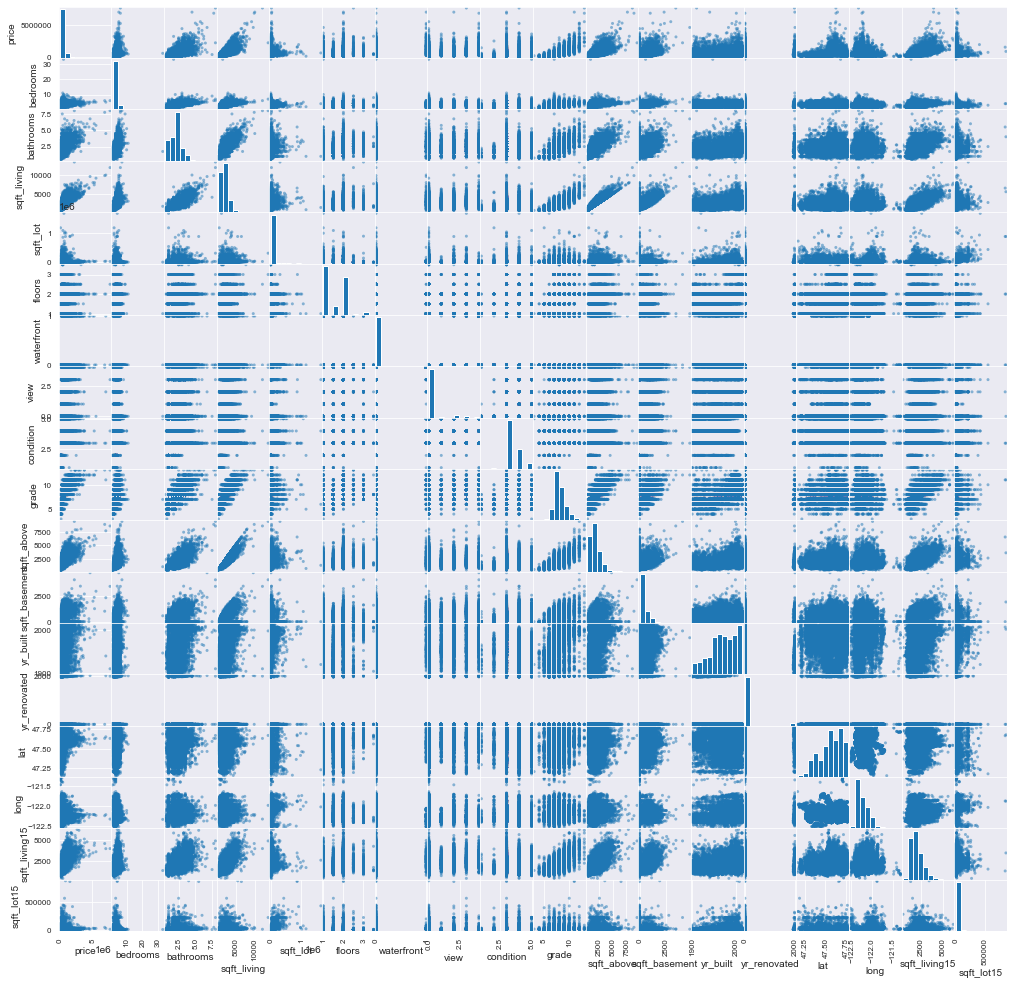

In [8]:
# Create Matrix
pd.plotting.scatter_matrix(df.drop(['id'], axis=1), figsize=(17,17));

**Observations:**
- Most histograms are positively skewed. I'll have to apply normalization to fit a linear regression model, probably remove some outliers.
- Some indication of multicollinearity when looking at: `sqft_living`, `sqft_above`, `sqft_living15` and `sqft_basement`
- Looks like `waterfront` is a binary variable
- `yr_renovated` also looks binary, but the problem is that some owners never renovated their houses.

Since it's hard to go through every single scatter plot and spot relationships, I will create a correlation matrix.

**[Go back to Table of Contents](#toc)**

### Correlation Matrix <a class="anchor" id="cm"></a>

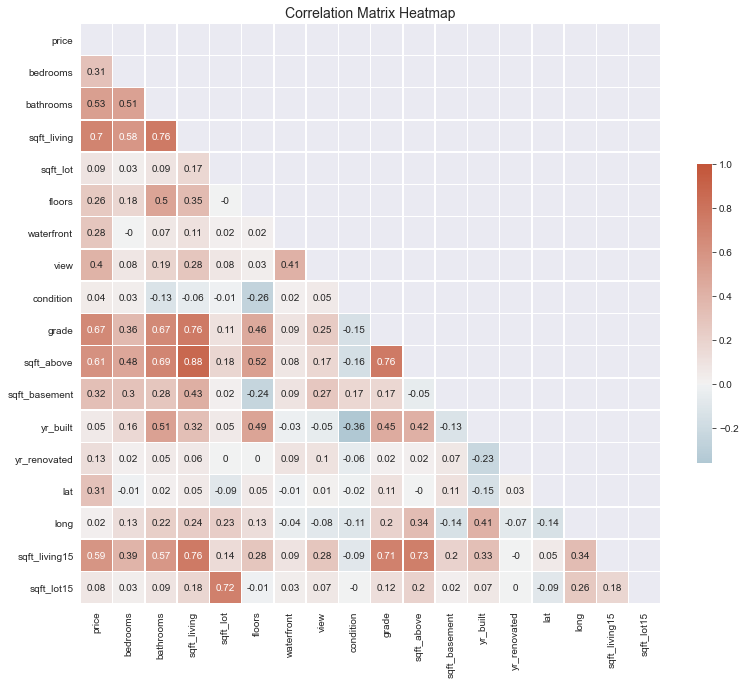

In [9]:
# Correlation numbers
corr = df.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Title
plt.title('Correlation Matrix Heatmap', size=14);

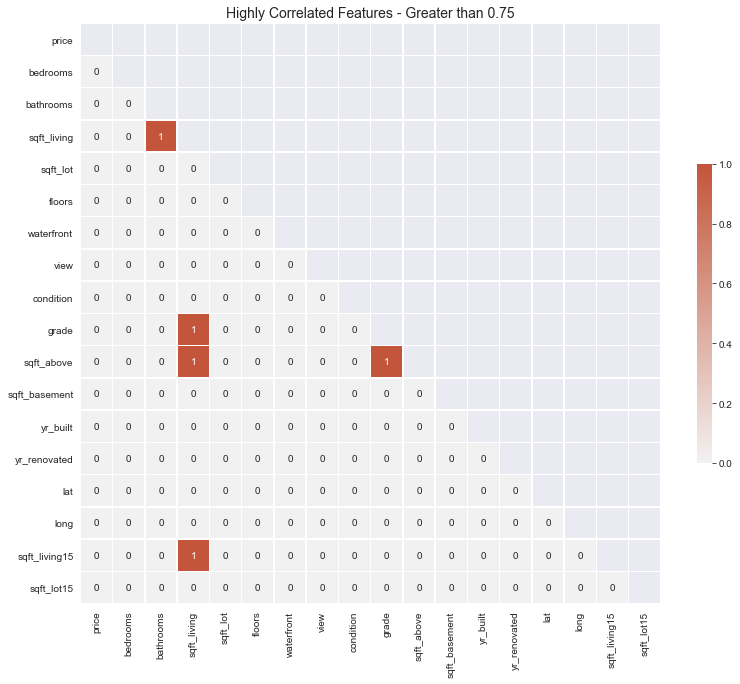

In [10]:
# Create a Binary DataFrame with a thresold of 0.75
high_corr = abs(corr) > 0.75

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(high_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(high_corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# Title
plt.title('Highly Correlated Features - Greater than 0.75', size=14);

**Observations:**
- First Matrix: As potential features of the model, given their correlation with `price` (>0.65), the following data points should be part of the model: `sqft_living` and `grade`.
- Second Matrix: some highly correlated variables: `bathrooms`, `sqft_living`, `sqft_living15`, `sqft_above` and `grade`.

**[Go back to Table of Contents](#toc)**

### Histograms of all features <a class="anchor" id="hist"></a>
Continuing the exploration of the dataset, looking at the histograms and distributions of variables will give me a good idea of whether there are some skewed or normal distributions. With that information, I can gauge how much work will be necessary to transform some of them since a Linear Regression model performs well on normally distributed features.

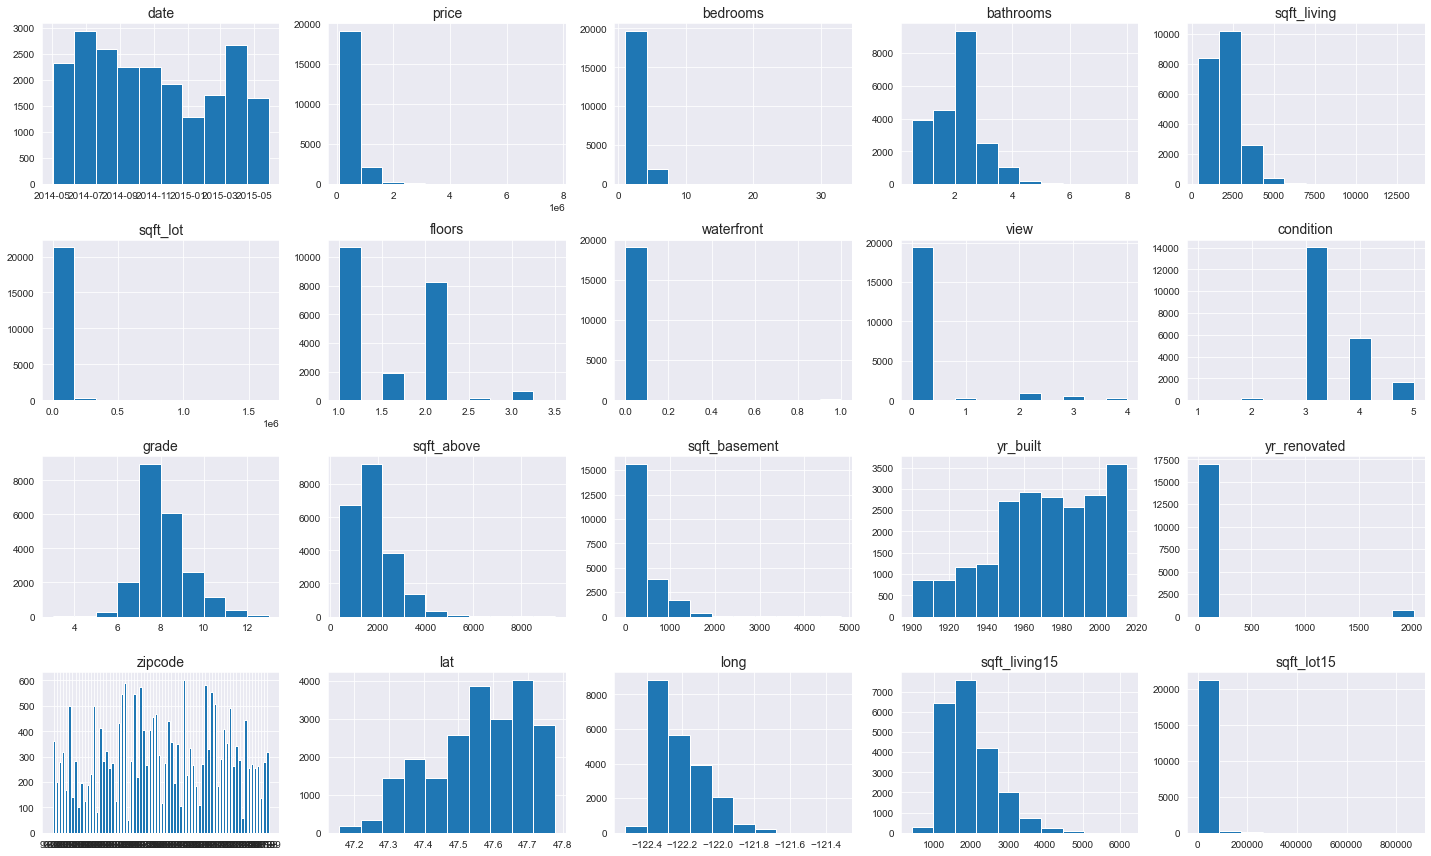

In [11]:
# Plot Columns
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12))

# Columns to plot
columns = list(df.columns)
columns.remove('id')

# Go through columns
for idx, column in enumerate(columns):

    # Create Series with column data
    col_series = df[column]

    # If Object/String then I plot it differently
    if col_series.dtype == object:

        # Group by column
        to_plot = df.groupby(column).count()['id'].reset_index()

    # Calculate position in chart
    row_n = (idx // 5)
    col_n = (idx % 5)

    # Plot Histogram or Bar Chart
    if col_series.dtype == object:        
        axes[row_n][col_n].bar(to_plot[column], to_plot['id'])
    else:
        axes[row_n][col_n].hist(col_series)

    # Set Title
    axes[row_n][col_n].set_title(column, size=14)

plt.tight_layout()
plt.show();

**Observations:**
- Here, I can see that `grade` is close to being normally distributed.
- While most features are heavily skewed.
- `date` is slightly skewed with more data points for 2014, not sure if that will impact the model.
- `zipcode` is not well balanced. I see some peaks and lows. Potentially this could cause some problems when modeling, adding some bias towards more frequent Zip Codes.

**[Go back to Table of Contents](#toc)**

# Questions<a class="anchor" id="q"></a>
### When were houses built? Is the Number of New Houses growing over time? <a class="anchor" id="q1"></a>
#### <span style="color:green">**Business-relevant point**</span>
> A good sign of a Healthy Market would be to see the No. of New Houses growing over the years. I assume that in a declining region, with not jobs/companies, people would likely move to different regions instead of building new houses. New houses could mean that:
> - High demand: more people are moving to Seattle, and companies are building houses.
> - Residents are building new houses: residents are looking for new houses, and they end up building their own.
> 
> Either way, it would be good to look at an upward trend if you are a Real Estate Agency firm.

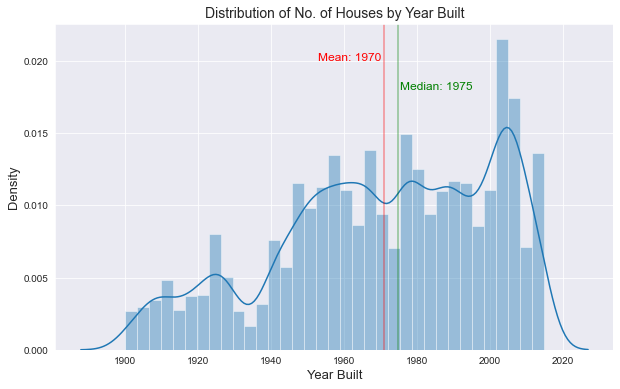

In [12]:
# Create figure to plot
fig = plt.figure(figsize=(10,6))

# Plot histogram
sns.distplot(df['yr_built'])

# Median/Median
yr_built_mean = df['yr_built'].mean()
yr_built_median = df['yr_built'].median()
plt.axvline(yr_built_mean, color='red', alpha=0.4)
plt.axvline(yr_built_median, color='green', alpha=0.4)

# Create Texts
plt.text(yr_built_mean - 18, 0.02, str('Mean: ' + str(int(yr_built_mean))), size=12, color='red')
plt.text(yr_built_median + 0.5, 0.018, str('Median: ' + str(int(yr_built_median))), size=12, color='green')

# Title and Labels
plt.title('Distribution of No. of Houses by Year Built', size=14)
plt.ylabel('Density', size=13)
plt.xlabel('Year Built', size=13)

plt.show();

#### Conclusion:
- I see a growing number of new houses over the years. From a business perspective, that's a healthy sign for the region. If Seattle were in decline, people probably would not build new houses.

**[Go back to Table of Contents](#toc)**

### What's the impact of `date` in `price`? Have prices changed over time? <a class="anchor" id="q2"></a>
With this question, I expect to understand whether houses have been appreciated over time. It's common sense to think that prices of proprieties change. However, do I have enough data to see that? And is that relevant to the model at all?

#### <span style="color:green">**Business-relevant point**</span>
> Moreover, I believe this question would be interesting for the Real Estate Agency firm as well. I don't think they would move/add businesses to a region where houses are losing value ( _unless they know something that nobody knows, of course_ ). Growing prices would be a good indication of a healthy real estate market.

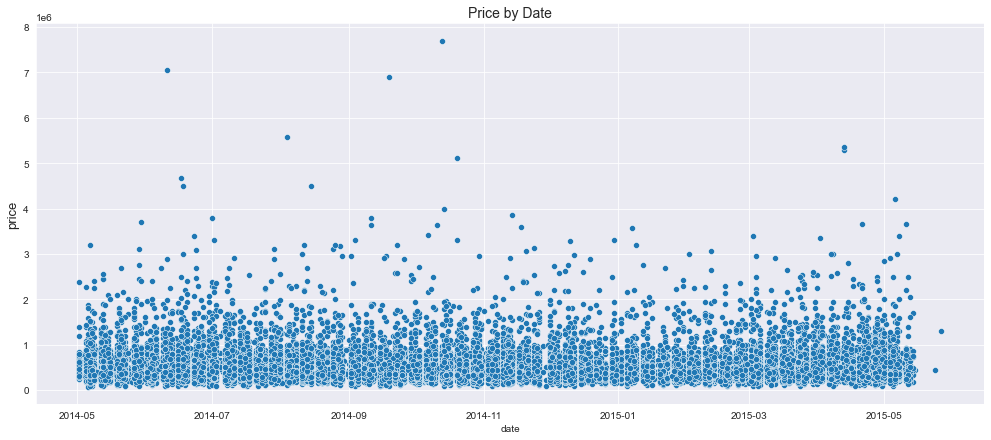

In [13]:
# Create figure to plot
fig = plt.figure(figsize=(17,7))

# Scatter plot of Price by Date
sns.scatterplot(x="date", y="price", data=df, legend=False)

# Title and y-axis label
plt.title('Price by Date', size=14)
plt.ylabel('price', size=13)
plt.show();

Except for some outliers, I can see that it's pretty randomly distributed and hard to tell whether there's an upward trend.

### House Prices over time by `zipcode`
However, I might be losing some trends by looking at all Zip Codes at the same time. Therefore, I'm going to plot the same chart by Zip Code. However, instead of just randomly plotting all of them, first I'm going to:
1. Make sure charts are comparable, with an axis on the same scale.
2. Order Zip Codes by the Standard Deviation of Prices, so I can see variation growing.

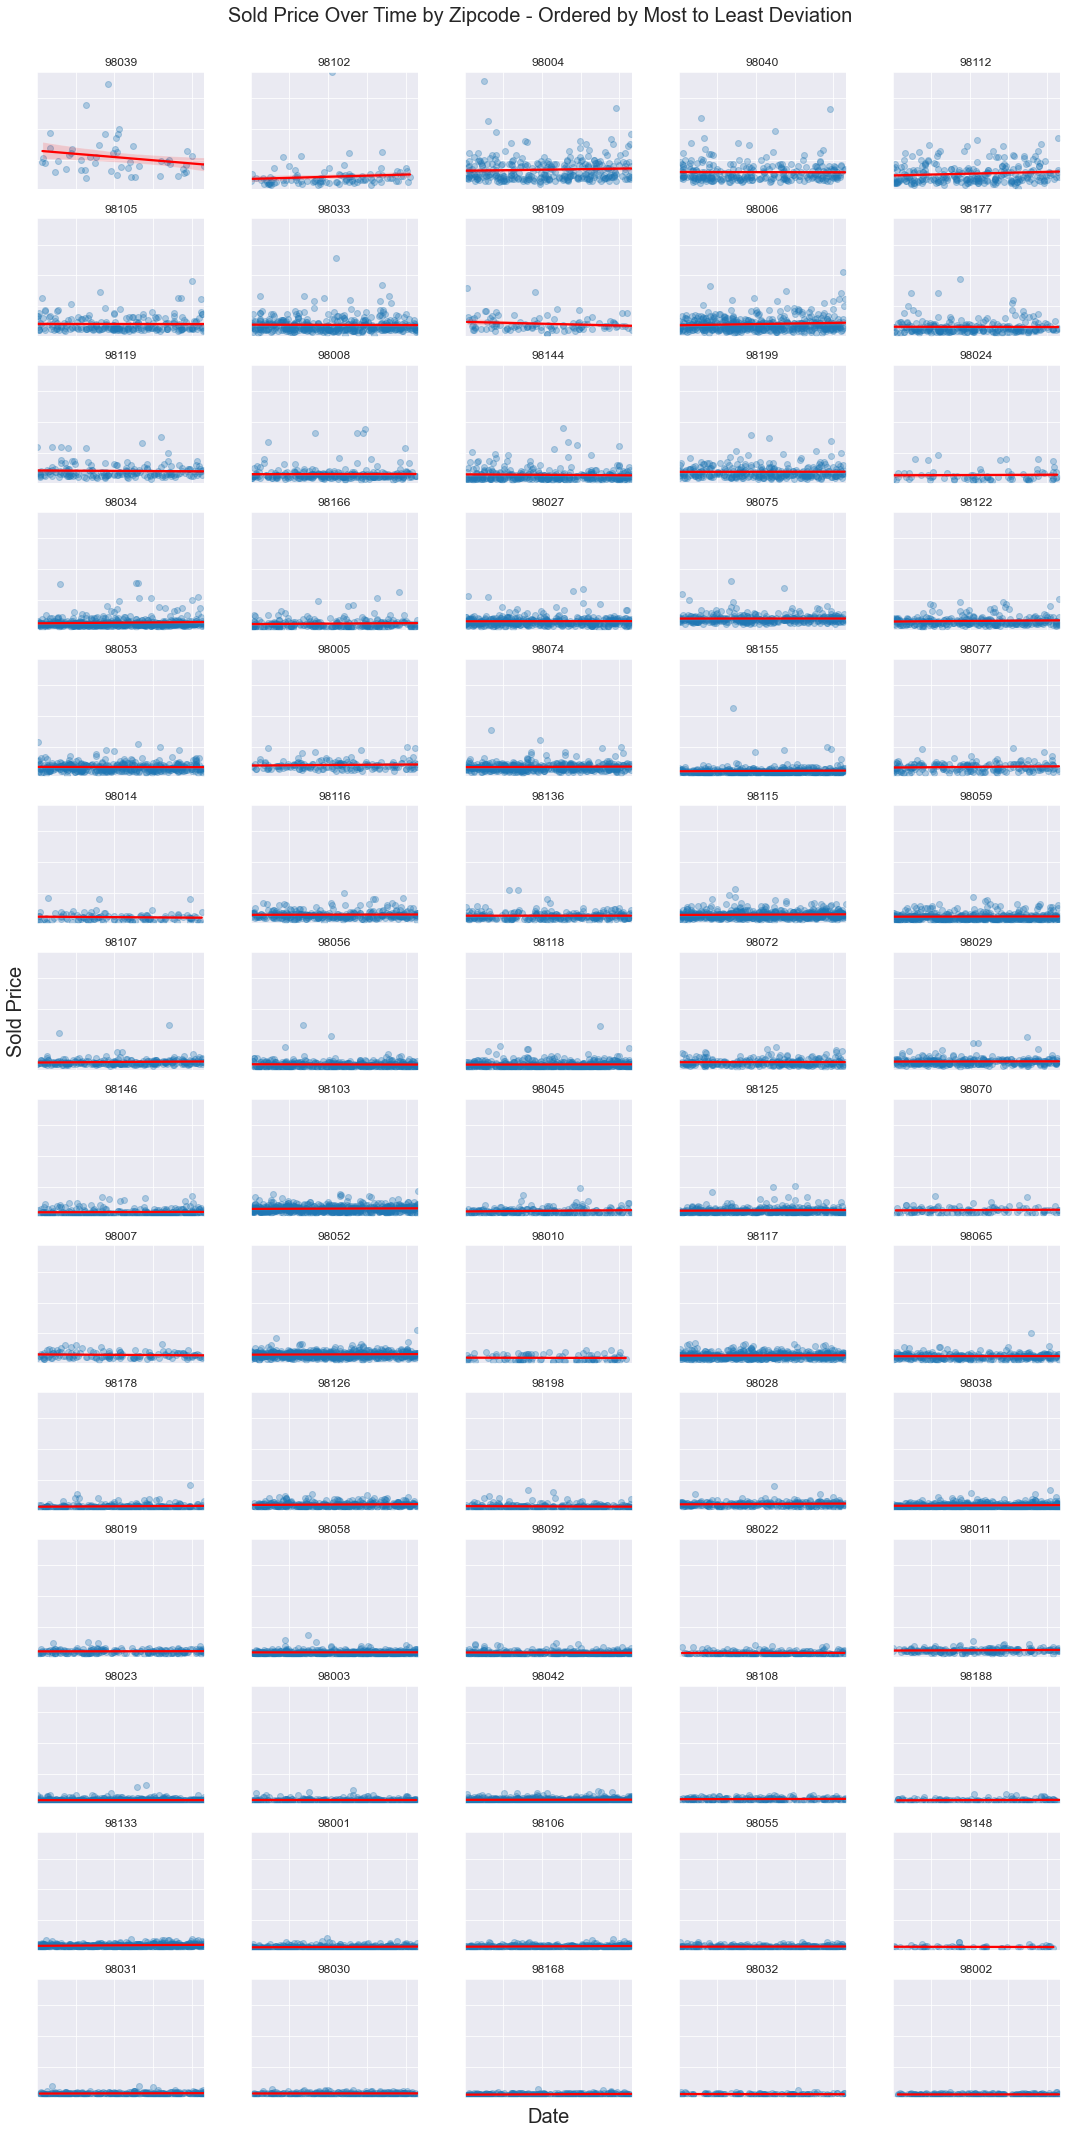

In [14]:
# Plot Columns
fig, axes = plt.subplots(nrows=14, ncols=5, figsize=(15,30))

# Tight Layout of Figure - Make charts closer to each other
fig.tight_layout()

# Order Zip Codes by Price Standard Deviation
zipcode_std_price = df.groupby('zipcode').std()['price'].sort_values(ascending=False).reset_index()

# Create copy to plot
df_copy = df.copy()
df_copy['date_rank'] = df_copy['date'].rank()

# Calculate min and max of x and y axis, so I are using the same scales to compare them
xmin = df_copy['date_rank'].min()
xmax = df_copy['date_rank'].max()
ymin = df_copy['price'].min()
ymax = df_copy['price'].max()

# Loop through zipcodes to plot
for idx, zipcode in enumerate(zipcode_std_price['zipcode'].unique()):
    
    # Calculate chart position
    col_n = idx % 5
    row_n = idx // 5
    
    # Create dataframe to plot
    to_plot = df_copy[df_copy['zipcode'] == zipcode]
    
    # Plot
    sns.regplot(x="date_rank", y="price", data=to_plot, ax=axes[row_n][col_n], 
                scatter_kws={'alpha': 0.3}, line_kws={'color':'red'})
    
    # Add Latitude Y Label
    if row_n == 6 and col_n == 0:
        axes[row_n][col_n].set_ylabel('Sold Price', fontsize=20)
    else:
        axes[row_n][col_n].set_ylabel(None)
        
    # Add Longitude X Label
    if row_n == 13 and col_n == 2:
        axes[row_n][col_n].set_xlabel('Date', fontsize=20)
    else:
        axes[row_n][col_n].set_xlabel(None)
        
    # Remove Ticks from Axis
    axes[row_n][col_n].set_yticklabels([])
    axes[row_n][col_n].set_xticklabels([])
    
    # Set Title to zipcode
    axes[row_n][col_n].set_title(zipcode)
    
    # Set Axis Min and Max
    axes[row_n][col_n].set_xlim([xmin,xmax])
    axes[row_n][col_n].set_ylim([ymin,ymax])

# Add Title and Subtitle
fig.suptitle("Sold Price Over Time by Zipcode - Ordered by Most to Least Deviation", fontsize=20)

# Adjust Header Space
plt.subplots_adjust(top=0.95)
plt.show();

**Observations:**
- It's hard to say with confidence that some Zip Codes prices went up during the year. Of course, the Zip Code is not the only factor, but I'd think of it as an important one. Also, looking at a chart is not the best way to find trends unless they're obvious.
- It's interesting to see that some Zip Codes don't vary much in price while others have higher deviation. That might be a good indication that I need to consider `zipcode` when modeling.

**[Go back to Table of Contents](#toc)**

### What's the importance of Zipcode and Coordinates in `price`? <a class="anchor" id="q3"></a>
I'd expect to see Price differences among Zip Codes. Probably in every place, there are expensive or cheap neighborhoods. Moreover, I'm trying to understand whether `zipcode` is a good proxy of the combination of `lat/long`. I would hypothesize that `zipcode` does help. However, if I need to get to a more granular level, using the coordinates might be the best option.

#### <span style="color:green">**Business-relevant point**</span>
> Also, from a business standpoint, it's essential for my employer to understand which regions have higher prices and if there's something specific to the area that justifies that price difference. This information might help the company to decide in which regions to focus on/allocate more resources. Of course, `price` is not the only data point relevant to this question. However, it would be an important one.

#### Median Price by Zip Code
First, I'm grouping all records by zipcode and looking at the distribution of the median price.

In [15]:
# Dataframe of Median Sold Price by Zipcode in Thousands of dollars
zipcode_median_price = df.groupby('zipcode').median()['price'].reset_index()
zipcode_median_price.columns = ['zipcode', 'median_price']
zipcode_median_price['median_price'] = zipcode_median_price['median_price'] / 1000
zipcode_median_price['median_price'] = zipcode_median_price['median_price'].round(2)

Let's look at the distribution of median prices.

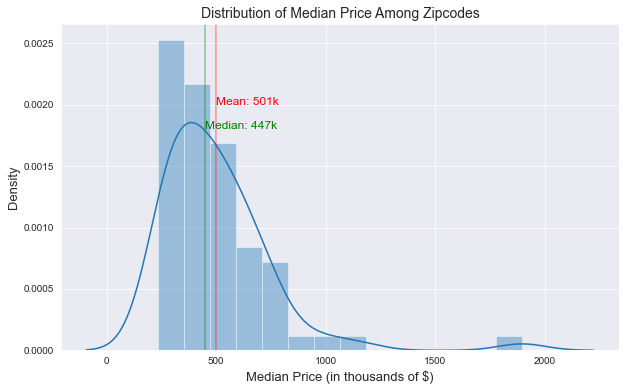

In [16]:
# Create figure to plot
fig = plt.figure(figsize=(10,6))

# Plot histogram
sns.distplot(zipcode_median_price['median_price'])

# Median/Median
median_price_mean = zipcode_median_price['median_price'].mean()
median_price_median = zipcode_median_price['median_price'].median()
plt.axvline(median_price_mean, color='red', alpha=0.4)
plt.axvline(median_price_median, color='green', alpha=0.4)

# Create Texts
plt.text(median_price_mean, 0.002, str('Mean: ' + str(int(median_price_mean)) + 'k'), size=12, color='red')
plt.text(median_price_median , 0.0018, str('Median: ' + str(int(median_price_median)) + 'k'), size=12, color='green')


plt.title('Distribution of Median Price Among Zipcodes', size=14)
plt.ylabel('Density', size=13)
plt.xlabel('Median Price (in thousands of $)', size=13)
plt.show();

I can definitely see some outliers. To be sure, I'm calculating the z-score.

In [17]:
# Calculate Z-Score so I can easily spot outliers
zipcode_median_price['z_score'] = (
                                    (zipcode_median_price['median_price'].mean() 
                                    - zipcode_median_price['median_price']) 
                                    / 
                                    zipcode_median_price['median_price'].std()
                                    )

# Show top/bottom 10
display(zipcode_median_price.sort_values('z_score').head())
display(zipcode_median_price.sort_values('z_score').tail())

zipcode  median_price   z_score
24   98039       1895.00 -5.461315
3    98004       1150.00 -2.542320
25   98040        993.75 -1.930115
48   98112        915.00 -1.621563
4    98005        765.48 -1.035727

zipcode  median_price   z_score
67   98188         264.0  0.929129
0    98001         260.0  0.944801
20   98032         249.0  0.987900
64   98168         235.0  1.042754
1    98002         235.0  1.042754

98039 is an outlier, with a `z_score` of -5.46. Also, notice that I'm calculating the Z-Score of Median Prices, not Average. Average prices would be much higher.

> **Note for model:** I'm going to keep the outliers in mind when building the model. Most likely, I'm going to remove some of those houses.

### Plot in Map using Zip Codes
Next, I'm curious to see whether the most expensive Zip Codes are in the same region. To achieve that, I think a good way would be to plot the Zip Code's median price on a map.

In [18]:
# Import WA Zipcode Coordinates (found them online)
# https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=WA
wa_zipcode_coord = pd.read_csv('us-zip-code-latitude-and-longitude.csv', delimiter=';')
wa_zipcode_coord['zipcode'] = wa_zipcode_coord['Zip'].astype(str)
wa_zipcode_coord.head()

Zip       City State   Latitude   Longitude  Timezone  \
0  98849  Riverside    WA  48.528793 -119.452760        -8   
1  99251    Spokane    WA  47.653568 -117.431742        -8   
2  98247    Everson    WA  48.900256 -122.320950        -8   
3  98004   Bellevue    WA  47.618371 -122.203080        -8   
4  98125    Seattle    WA  47.716648 -122.303080        -8   

   Daylight savings time flag               geopoint zipcode  
0                           1   48.528793,-119.45276   98849  
1                           1  47.653568,-117.431742   99251  
2                           1   48.900256,-122.32095   98247  
3                           1   47.618371,-122.20308   98004  
4                           1   47.716648,-122.30308   98125

In [19]:
# Merge with median prices
median_price_coord = pd.merge(zipcode_median_price, 
                              wa_zipcode_coord[['zipcode', 'Latitude', 'Longitude']], 
                              on='zipcode', how='left')

# There is one zipcode missing coordinates
median_price_coord.loc[median_price_coord['zipcode'] == '98077', 'Latitude'] = 47.75223000 
median_price_coord.loc[median_price_coord['zipcode'] == '98077', 'Longitude'] = -122.05556600

In [20]:
# Create list with color gradient - from white to red
white = Color("white")
colors = list(white.range_to(Color("red"), len(median_price_coord)))
colors_df = pd.DataFrame(colors, columns=['color'])

# Reset order to join colors with prices
median_price_coord = median_price_coord.sort_values('median_price').reset_index(drop=True)
median_price_coord = median_price_coord.join(colors_df)
median_price_coord.head()

zipcode  median_price   z_score   Latitude  Longitude    color
0   98002         235.0  1.042754  47.304221 -122.21602    white
1   98168         235.0  1.042754  47.491327 -122.30270  #fdfdfd
2   98032         249.0  0.987900  47.388254 -122.25932  #fbfbfb
3   98001         260.0  0.944801  47.303722 -122.26608  #faf9f9
4   98188         264.0  0.929129  47.450321 -122.27472  #f8f7f7

In [21]:
# Create Map Instance
map = folium.Map(location=[47.55, -122.2], default_zoom_start=12, tiles="CartoDB positron")

# Add Circles to Map - Size/Color will be based on price
for i in range(0,len(median_price_coord)):
    folium.Circle(
        location=[median_price_coord.iloc[i]['Latitude'], median_price_coord.iloc[i]['Longitude']],
        popup=('Zipcode: ' + str(median_price_coord.iloc[i]['zipcode']) + 
               '\t Median Price: $' + str(median_price_coord.iloc[i]['median_price']) + 'k'),
        radius=median_price_coord.iloc[i]['median_price'],
        color=str(median_price_coord.iloc[i]['color']),
        fill=True,
        fill_color='crimson'
                    ).add_to(map)

# Show map
print('Average Price by Zip Code - Bigger Circles represent Higher Prices')
map

Average Price by Zip Code - Bigger Circles represent Higher Prices


Cool, I can easily spot the most expensive Zip Codes. It's interesting to see that most of them are agglomerated in the same area, which seems to be Downtown Seattle + Bellevue.

### Plot using coordinates

Next, instead of grouping houses by `zipcode` and calculating the mean price. I will plot the actual data for every house in a scatter plot, utilizing the coordinates.

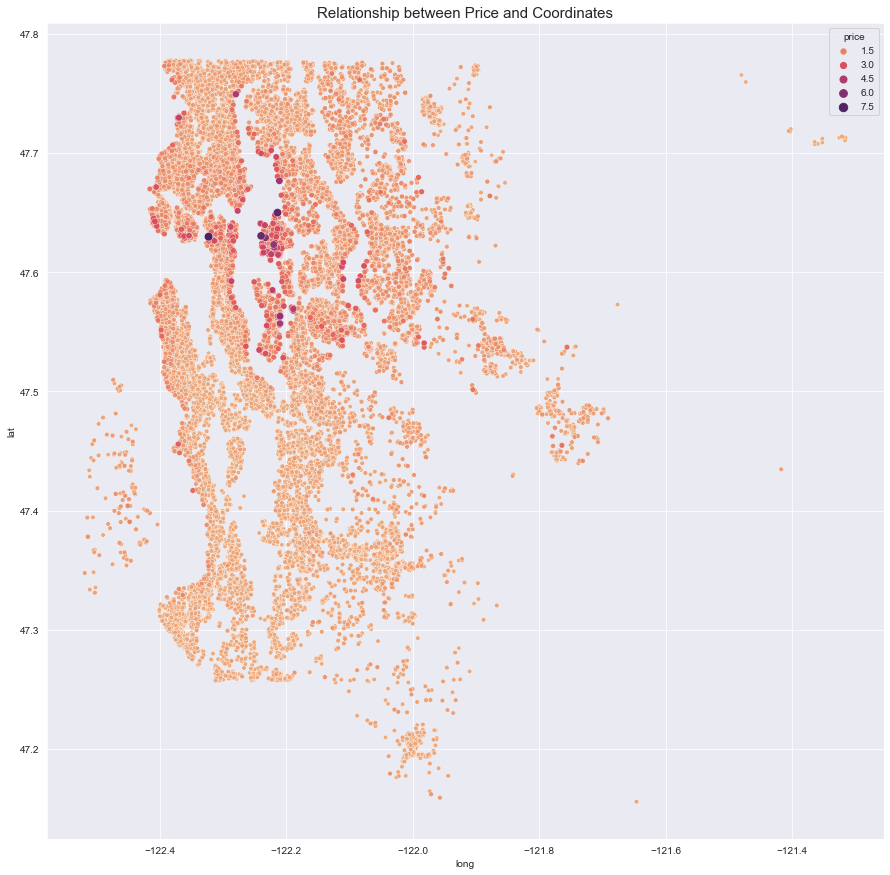

In [22]:
# Create Figure to Plot
fig = plt.figure(figsize=(15,15))

# Scatter Plot of Prices by Coordinates
sns.scatterplot(x="long", y="lat", hue="price", data=df.sort_values('price'), 
                legend=True, size="price", palette='flare')
plt.title('Relationship between Price and Coordinates', size=15)
plt.show();

Here I can see that places on Lake Washington's shoreline close to Seattle Downtown are more expensive. 

### Variation of prices within the same `zipcode`

Next, I'm curious to see the variation of prices within the same Zip Code areas. If I can see some variability, it will be a good reason to assume that Zip Codes are generalizing prices too much and use the coordinates to calculate prices accurately.

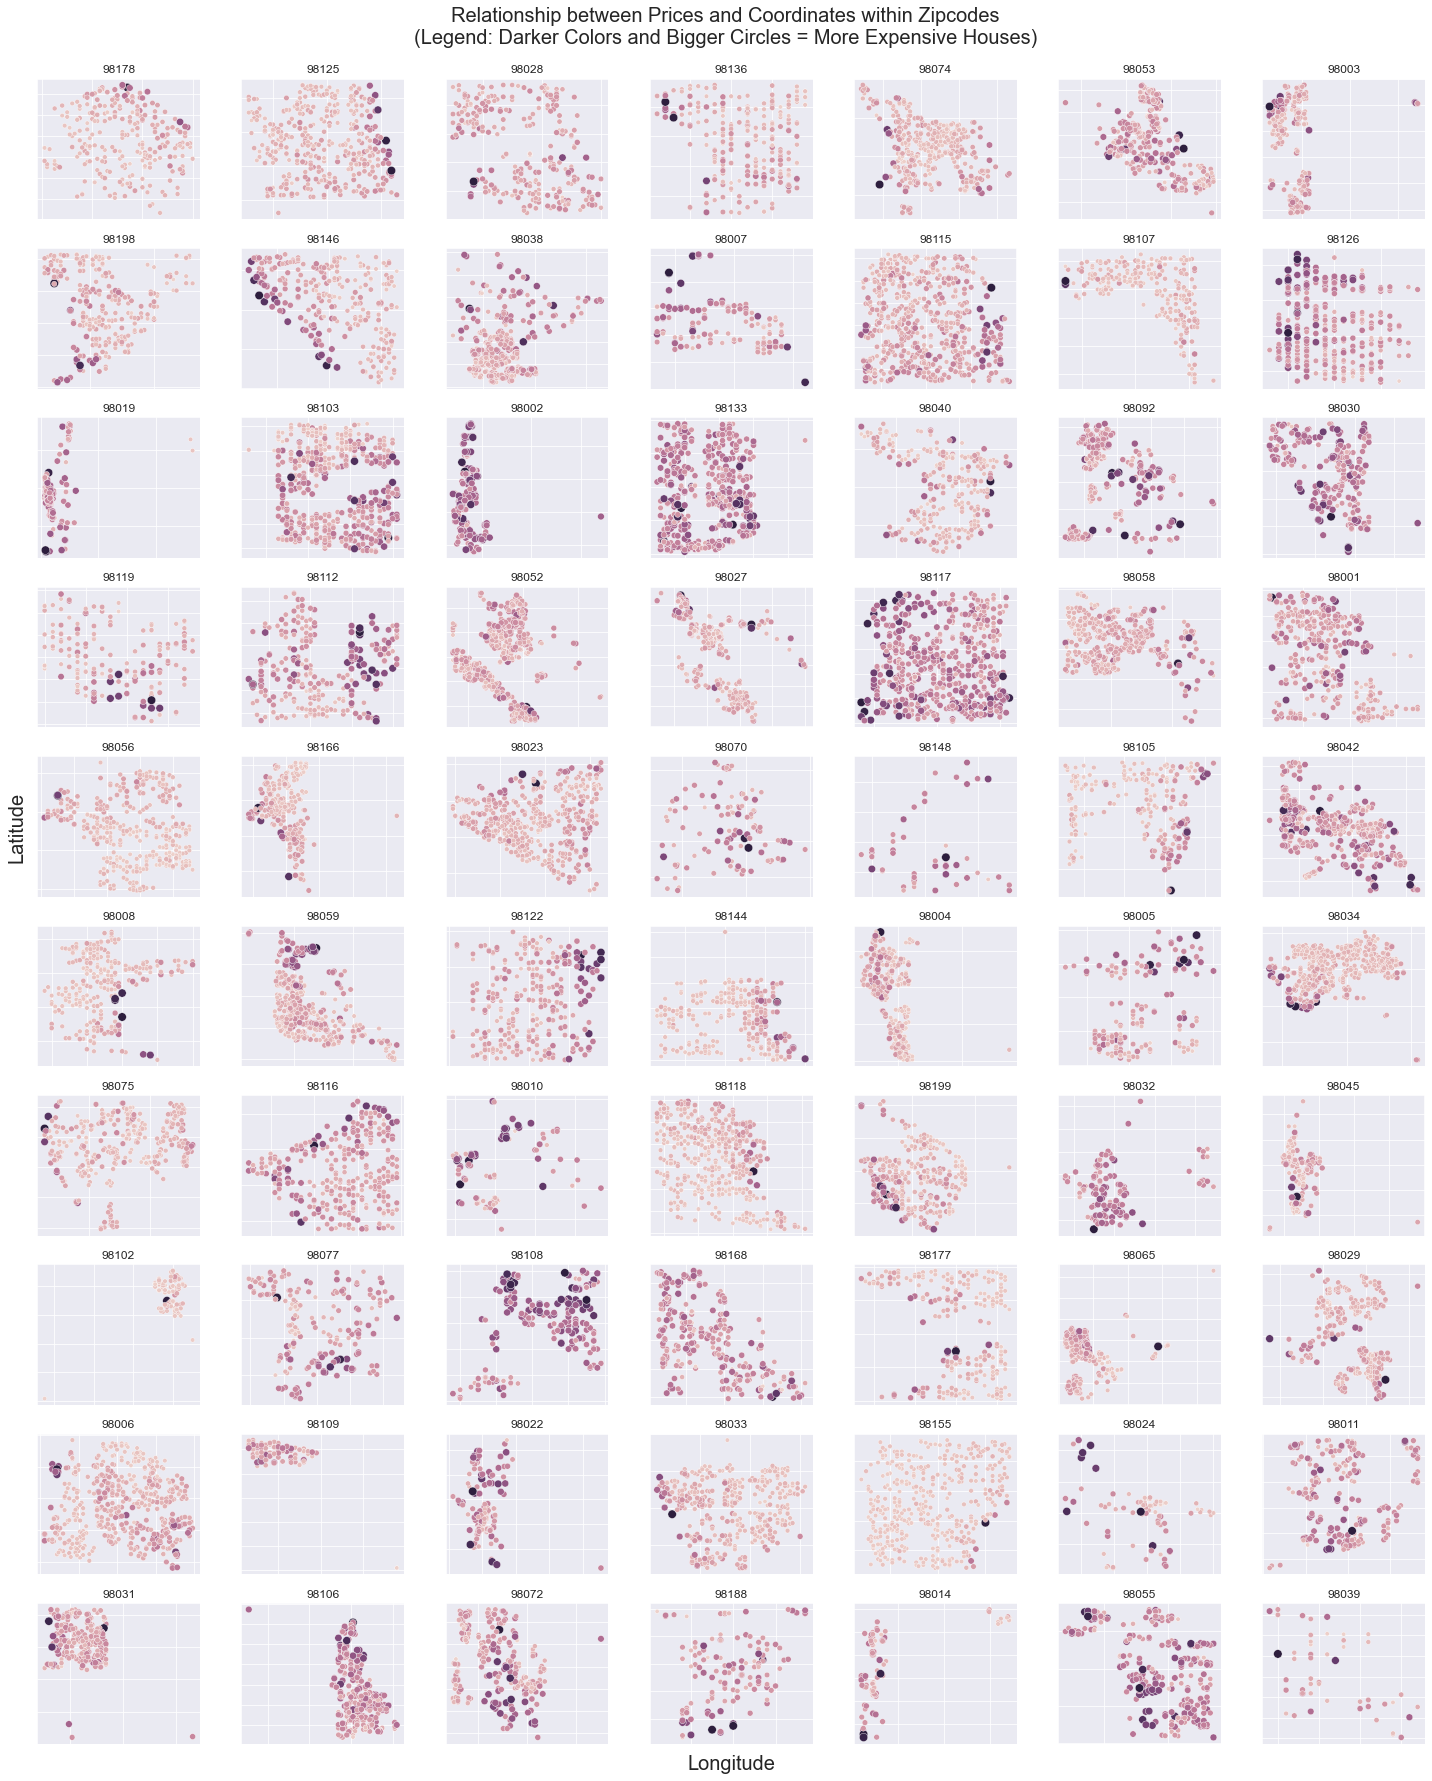

In [23]:
# Plot Columns
fig, axes = plt.subplots(nrows=10, ncols=7, figsize=(20,25))

# Tight Layout of Figure - Make charts closer to each other
fig.tight_layout()

# Loop through zipcodes to plot
for idx, zipcode in enumerate(df['zipcode'].unique()):
    
    # Calculate chart position
    col_n = idx % 7
    row_n = idx // 7
    
    # Create dataframe to plot
    to_plot = df[df['zipcode'] == zipcode]
    
    # Plot
    sns.scatterplot(x="long", y="lat", hue="price", data=to_plot, 
                    legend=False, ax=axes[row_n][col_n], size="price")
    
    # Add Latitude Y Label
    if row_n == 4 and col_n == 0:
        axes[row_n][col_n].set_ylabel('Latitude', fontsize=20)
    else:
        axes[row_n][col_n].set_ylabel(None)
        
    # Add Longitude X Label
    if row_n == 9 and col_n == 3:
        axes[row_n][col_n].set_xlabel('Longitude', fontsize=20)
    else:
        axes[row_n][col_n].set_xlabel(None)
        
    # Remove Ticks from Axis
    axes[row_n][col_n].set_yticklabels([])
    axes[row_n][col_n].set_xticklabels([])
    
    # Set Title to zipcode
    axes[row_n][col_n].set_title(zipcode)

# Add Title and Subtitle
fig.suptitle("""Relationship between Prices and Coordinates within Zipcodes
(Legend: Darker Colors and Bigger Circles = More Expensive Houses)""", fontsize=20)

# Adjust Header Space
plt.subplots_adjust(top=0.94)
plt.show();

#### Conclusions:
From the first map, it's possible to see a concentration of the highest median prices (or most expensive Zip Codes) in Bellevue and Seattle centers. Therefore, it's important to use the location of the house.
- Moreover, after plotting prices using the coordinates, it's possible to see that places in the shoreline of Lake Washington and near Downtown Seattle are more expensive. This makes me think that using Zip Code might be too much of a generalization since I would miss these subtle differences within Zip Codes and the gradient increase/decrease of prices based on the coordinates.
- Finally, when plotting the Prices within each Zip Code, I can see how prices vary within the same Zip Code area—supporting the idea that keeping the coordinates is beneficial for the accurate prediction of prices.

#### <span style="color:green">**Business-relevant point**</span>
> The most expensive Zip Codes/Areas of the dataset are known, and the Agency might choose to have more presence in these areas. However, it's essential to look at other data points before making that call.

**[Go back to Table of Contents](#toc)**

### Is the dataset evenly distributed in terms of houses by Zip Code? <a class="anchor" id="q4"></a>
I'm afraid that Zip Codes with more records will add bias to my model _(which supports the idea of doing one-hot encoding of Zip Code + coordinates to capture variability within Zip Codes)_.

#### <span style="color:green">**Business-relevant point**</span>
> On the other hand, the unbalanced No. of Records would tell a different story. Given that I'm looking at a dataset of sold houses, it would not be entirely wrong to imply that certain Zip Codes sell more than others. The reason for that could be several (cheaper houses, higher demand). However, it's also essential to take into consideration the business model of the Agency firm.

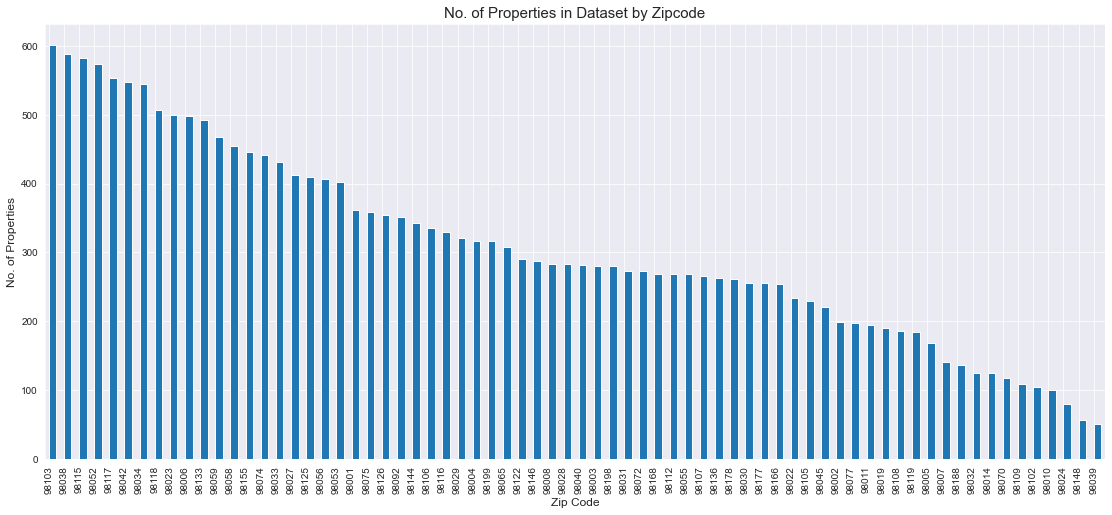

In [24]:
# Count No. of Houses by Zip Code and sort Zip Codes by Count so I get a beautiful chart
zipcode_count = df.groupby('zipcode').count()['id'].sort_values(ascending=False).reset_index()
zipcode_count.columns = ['zipcode', 'count']

# Plot
zipcode_count.plot.bar('zipcode', 'count', align='edge', figsize=(19,8), legend=False)
plt.title('No. of Properties in Dataset by Zipcode', size=15)
plt.xlabel('Zip Code', size=12)
plt.ylabel('No. of Properties', size=12)
plt.show();

Some Zip Codes are underrepresented. This might be fascinating information for the Real Estate Agency firm since some Zip Codes might be more profitable per unit sold. However, if there are fewer houses to be sold, it might make more sense to sell more houses in not-so-profitable Zip Codes.

> **Note for model:** Maybe some oversampling would be a good idea before creating it.

**[Go back to Table of Contents](#toc)**

### What's the Average Sold Price by Zip Code? <a class="anchor" id="q5"></a>
Continuing the analysis above, an excellent way to look at the data would be to understand which areas have higher prices. To achieve that, I'm going to calculate the average price by `zipcode`.

#### <span style="color:green">**Business-relevant point**</span>
>From a business standpoint, it would be interesting to see many sold houses in areas where the average price is high.

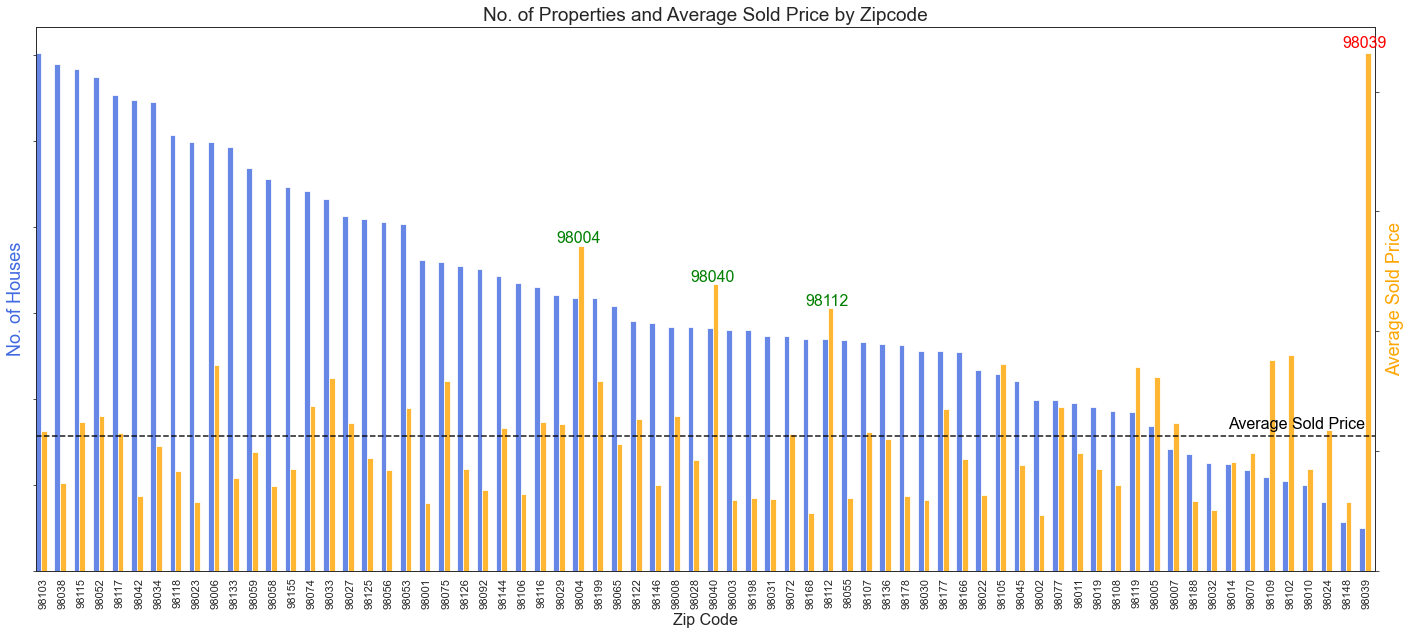

In [25]:
# Create DataFrame with average price by Zip Code
zipcode_avg_price = df.groupby('zipcode').mean()['price'].reset_index()
zipcode_avg_price.columns = ['zipcode', 'avg_price']

# Combine both
zipcode_metrics = pd.merge(zipcode_count, zipcode_avg_price, on='zipcode')

# Changing style momentarily to remove background grid
sns.set_style('white')

# Create Figure
fig = plt.figure(figsize=(24,10))

# Create matplotlib axes and secondary axes
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

# Plot
width = 0.3
zipcode_metrics.plot.bar('zipcode', 'count', legend=False, width=width,
                       ax=ax, position=1, align='edge', color='royalblue', alpha=0.8)
zipcode_metrics.plot.bar('zipcode', 'avg_price', legend=False, width=width,
                           ax=ax2, position=0, align='edge', color='orange', alpha=0.8)

# Set Labels
plt.title('No. of Properties and Average Sold Price by Zipcode', size=19)
ax.set_ylabel('No. of Houses', color='royalblue', size=18)
ax2.set_ylabel('Average Sold Price', color='orange', size=18)
ax.set_xlabel('Zip Code', size=16)
ax2.set_xlabel(None)
ax.set_yticklabels([None])
ax2.set_yticklabels([None])
ax.set_xticklabels(zipcode_count['zipcode'], fontsize = 11, ha='left')

# Create Line with Average Sold Price
ax2.axhline(zipcode_metrics['avg_price'].mean(), color='black', linestyle='--', alpha=0.9)
ax2.text(62, zipcode_metrics['avg_price'].mean() + 30000, 'Average Sold Price', color='black', size=16)

# Loop through Zip Codes to add texts
for zipcode in ['98004', '98040', '98112', '98039']:
    
    # Calculate x in chart (subtract one for visual purposes)
    x_coord = zipcode_metrics[zipcode_metrics['zipcode'] == zipcode].index[0] - 1
    
    # Calculate y position in chart (multiply by 1.01 for visual purposes)
    y_coord = zipcode_metrics[zipcode_metrics['zipcode'] == zipcode]['avg_price'].values[0] * 1.01

    # Add Condition to add text with different color
    if zipcode != '98039':
        # Add Text
        ax2.text(x_coord, y_coord, zipcode, color='green', size=16)
    else:
        ax2.text(x_coord, y_coord, zipcode, color='red', size=16)

plt.show();

It's possible to see some Zip Codes where the Average Sold Price is above the Zip Code Average. Those are potentially the areas of interest for us.

**Observations:**
- `98039` is an outlier <span style="color:red">(red text in chart)</span>, possibly adding some difficulties to spot good Zip Codes.
- `98004`, `98040` and `98112` could be good Zip Codes <span style="color:green">(green texts in the chart)</span>, with Averages way above the dash-line and a good No. of Sold Houses.

**[Go back to Table of Contents](#toc)**

### What's the Total Sold by Zip Code? <a class="anchor" id="q6"></a>
The next natural question then would be to calculate the sum of all houses by Zip Code. With that information, I attribute a value to Zip Codes.

#### <span style="color:green">**Business-relevant point**</span>
> With that information, I can identify Zip Codes that would add more to **Total Sold Value** to the business. By _Total Sold Value_ , I mean just the total amount of dollars sold in houses, which does not translate to actual revenue. However, it can be an excellent metric to analyze.

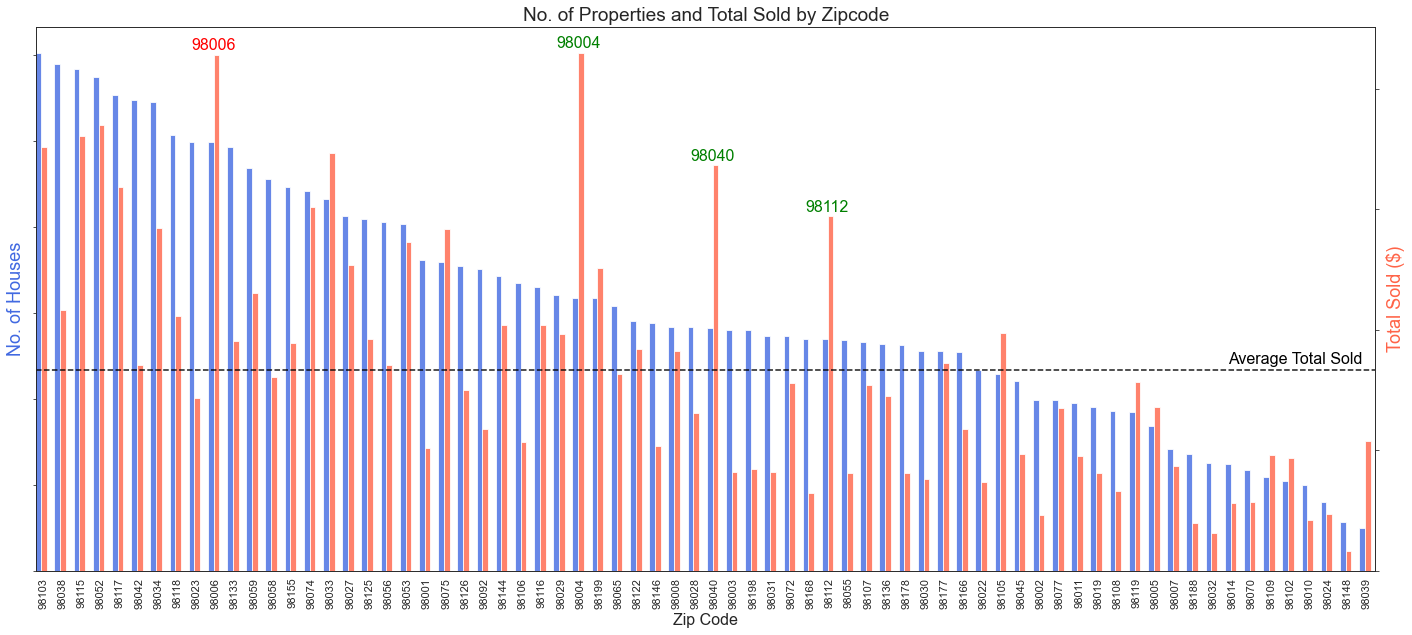

In [26]:
# Calculate Total Sold by Zip Code
zipcode_total = df.groupby('zipcode').sum()['price'].reset_index()
zipcode_total.columns = ['zipcode', 'total_sold']

# Combine with previous DataFrame
zipcode_metrics = pd.merge(zipcode_metrics, zipcode_total, on='zipcode')

# Create Figure
fig = plt.figure(figsize=(24,10))

# Create matplotlib axes and secondary axes
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

# Plot
width = 0.3
zipcode_metrics.plot.bar('zipcode', 'count', legend=False, width=width,
                       ax=ax, position=1, align='edge', color='royalblue', alpha=0.8)
zipcode_metrics.plot.bar('zipcode', 'total_sold', legend=False, width=width,
                           ax=ax2, position=0, align='edge', color='tomato', alpha=0.8)

# Set Labels
plt.title('No. of Properties and Total Sold by Zipcode', size=19)
ax.set_ylabel('No. of Houses', color='royalblue', size=18)
ax2.set_ylabel('Total Sold ($)', color='tomato', size=18)
ax.set_xlabel('Zip Code', size=16)
ax2.set_xlabel(None)
ax.set_yticklabels([None])
ax2.set_yticklabels([None])
ax.set_xticklabels(zipcode_count['zipcode'], fontsize = 11, ha='left')

# Create Line with Average Sold Price
ax2.axhline(zipcode_metrics['total_sold'].mean(), color='black', linestyle='--', alpha=0.9)
ax2.text(62, zipcode_metrics['total_sold'].mean() + 5000000, 'Average Total Sold', color='black', size=16)

# Loop through Zip Codes to add texts
for zipcode in ['98004', '98040', '98112', '98006']:
    
    # Calculate x in chart (subtract one for visual purposes)
    x_coord = zipcode_metrics[zipcode_metrics['zipcode'] == zipcode].index[0] - 1
    
    # Calculate y position in chart (multiply by 1.01 for visual purposes)
    y_coord = zipcode_metrics[zipcode_metrics['zipcode'] == zipcode]['total_sold'].values[0] * 1.01

    # Add Condition to add text with different color
    if zipcode != '98006':
        # Add Text
        ax2.text(x_coord, y_coord, zipcode, color='green', size=16)
    else:
        ax2.text(x_coord, y_coord, zipcode, color='red', size=16)

plt.show();

Very interesting to see the Total Sold amount by Zip Code. Definitely, Zip Codes with more Sold Houses will have higher Total Amounts, so it might not be the best way of looking at it. However, it's easy to spot some outperformers (a positive way to refer to outliers).

**Observations**:
- `98004`, `98040` and `98112` <span style="color:green">(green texts in chart)</span> impressed me again! With numbers way above the average and not too many houses, these Zip Codes seem to outperform others! For example, `98004` has a Total Sold Amount comparable to `98006` <span style="color:red">(red text in the chart)</span>, which is one of the Zip Codes with the most No. of Houses.

#### <span style="color:green">**Business-relevant point**</span>
> Although that's all very exciting, I still need to consider the business model before coming up with any recommendations. I'm going to focus on that later on.

Next, I think it makes sense to combine these data points into a table format rather than comparing charts to digest that information quickly.

In [27]:
# Round Average Price so it's readable
zipcode_metrics['avg_price'] = zipcode_metrics['avg_price'].round()
zipcode_metrics.head()

zipcode  count  avg_price   total_sold
0   98103    602   585049.0  352199365.0
1   98038    589   367091.0  216216884.0
2   98115    583   619944.0  361427439.0
3   98052    574   645244.0  370370186.0
4   98117    553   576835.0  318989649.0

Great. However, it's hard to compare numbers the way I was doing before, by taking the average, looking at it, comparing Zip Codes and concluding that something is better. I rather have a standard method of comparison. For that, I'm going to use the Z-Score of `avg_price` and `total_sold`. With that information, I can easily conclude that something is above 50% of Zip Codes, for example.

In [28]:
# Calcule Z-Scores
def z_score_calculator(field):
    """
    This function returns the Z-Score of a given column in a DataFrame
    
    Args:
      field(pandas.DataFrame): Column in a DataFrame with the variable to calculate the Z-Scores

    Returns:
      Z-Score of each element in column
    """
    # Calculate Mean and Standard Deviation
    field_mean = field.mean()
    field_std = field.std()
    
    # Calculate Z-Score
    field_z_score = (field - field_mean) / field_std
    
    return field_z_score

In [29]:
# Apply Z-Score to columns
zipcode_metrics['avg_price_z_score'] = zipcode_metrics[['avg_price']].apply(z_score_calculator, axis=0)
zipcode_metrics['total_sold_z_score'] = zipcode_metrics[['total_sold']].apply(z_score_calculator, axis=0)

Now that I have all Z-Scores, I'm going to keep only the ones above 1. <br>In a normal distribution, that would mean Zip Codes with higher Average Sold Price and Total Sold Amount than 84% of Zip Codes. The idea is to keep the top performers in both metrics.

In [30]:
zipcode_metrics[(zipcode_metrics['avg_price_z_score'] > 1) & (zipcode_metrics['total_sold_z_score'] > 1)]

zipcode  count  avg_price   total_sold  avg_price_z_score  \
28   98004    317  1356524.0  430018105.0           2.630716   
35   98040    282  1194874.0  336954366.0           2.096149   
41   98112    269  1096239.0  294888293.0           1.769969   

    total_sold_z_score  
28            2.618207  
35            1.692873  
41            1.274609

The results are the same! `98004`, `98040` and `98112` are the best Zip Codes in these two measurements.

#### <span style="color:green">**Business-relevant point**</span>
> These could be recommendations of Zip Codes for the Agency to enter the market. However, it doesn't take into consideration the business model.

**[Go back to Table of Contents](#toc)**

## Would the distance from Downtown Seattle be a good proxy for coordinates and Zip Code?<a class="anchor" id="coord_proxy"></a>
Since we're dealing with an unbalanced dataset in terms of Zip Codes, and Coordinates range vary little (Lat: 47.1 to 47.9 / Long: -123 to -121). An excellent way to use the house's location might be to calculate the distance from Seattle Downtown. 

To get the coordinates of Seattle Downtown, I just googled 'Seattle Downtown Coordinates' and got the following: 47.6050° N, 122.3344° W.

In [31]:
# Seattle Downtown Coordinates
downtown_coord = (47.6050, -122.3344)

# Create function to calculate distance
def distance_km(lat, long, ref_coord):
    """
    This function returns the distance between a coordinates.
    The reference coordinate is given.
    
    Args:
      df(pandas.DataFrame): DataFrame with the coordinates columns (latitude and longitude)

    Returns:
      Distance between coordinates in km.
    """
    # Calculate Distance
    distance = geodesic(ref_coord, (lat, long)).km
    
    return distance

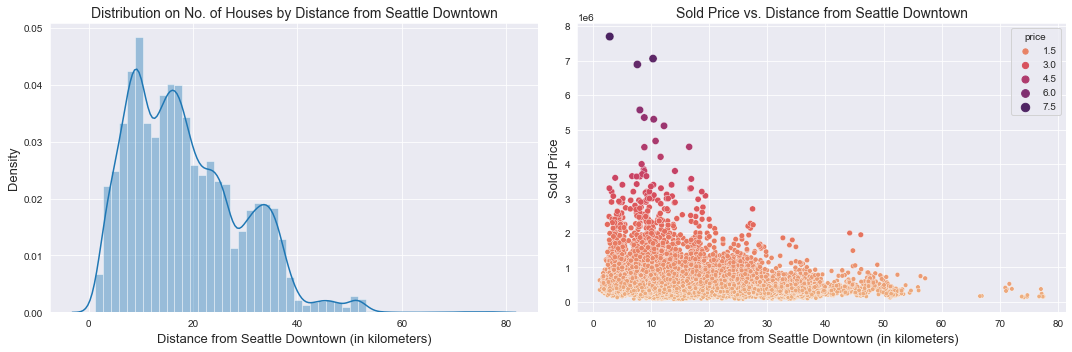

In [32]:
# Calculate distance from downtown
df['downtown_distance'] = df.apply(lambda x: distance_km(x['lat'], x['long'], downtown_coord), axis=1)

# Switching style back
sns.set_style('darkgrid')

# Create Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Plot histogram
sns.distplot(df['downtown_distance'], ax=axes[0])
axes[0].set_title('Distribution on No. of Houses by Distance from Seattle Downtown', size=14)
axes[0].set_ylabel('Density', size=13)
axes[0].set_xlabel('Distance from Seattle Downtown (in kilometers)', size=13)

# Scatter Plot of Prices by Coordinates
sns.scatterplot(x="downtown_distance", y="price", hue="price", data=df, 
                legend=True, size="price", palette='flare', ax=axes[1])
axes[1].set_title('Sold Price vs. Distance from Seattle Downtown', size=14)
axes[1].set_ylabel('Sold Price', size=13)
axes[1].set_xlabel('Distance from Seattle Downtown (in kilometers)', size=13)

fig.tight_layout()
plt.show();

#### Conclusions:
- Most houses are within a 20 km radius of Downtown Seattle.
- Most expensive houses are closer to Downtown Seattle.

**[Go back to Table of Contents](#toc)**

# Run different simulations to estimate Revenue<a class="anchor" id="rev"></a>
Even though these metrics provide exciting results, they don't take into consideration the actual Business Model. Next, I will come up with some assumptions and try to estimate how much money they'd have made in each Zip Code and find the optimal combination from a revenue perspective.

Going back to the Business Model:
- 5% Commission on Minimum Price.
- 7% Commission if Value Above Minimum Price.
- 30% Success Rate on Selling Houses and 10% of selling it above the Minimum Price, on Avg. by Agent.

#### Important Notes
1. **We're analyzing only sold houses:** Unfortunately, _the dataset includes only successful cases of sold houses_ , so I don't know how many of them were for sale but didn't succeed. This data point would help estimate how many houses they would be able to sell first of all. Since I don't have that data point, I'm going to come up with assumptions.
2. **Cost of an agent:** I don't have the _Number of Agents who will be working for the Agency_ and I'd think there would be _additional costs associated with them_.  For example, an annual salary + costs (benefits) + commission. I'm going to use the [average salary of an Intermediate Agent of USD 152,565 from this website.](https://www.zillow.com/agent-resources/blog/how-do-real-estate-agents-get-paid/). For the commission, I'm assuming that the **Agency gives 40% of the Total Commission (at Minimum Price or Above) back to the Agent**.
3. **Limitations on the distance between houses**: I checked on Google Maps the distance between two Zip Codes that are on opposite sides (Auburn, WA 98092, USA and Woodinville, WA 98077, USA). And driving would take one hour from one point to the other. So, I'm not going to take that as a constraint. However, ideally, I'd like to analyze the distances between Zip Codes to make sure it's manageable.
4. **Competitors:** There are other Agencies and, of course, one Agency will not be able to sell all the houses. Therefore, I'm going to come up with a % of houses managed by our firm.

#### Assumptions:
1. **Success Rate per Agent:** I'm going to use the **%30** and assume that it's normally distributed with a standard deviation of **%30**. Then, I will randomly generate the rates for each Agent and calculate the mean of that. Of course, a higher No. of Agents would get the company closer to the 30%, but I want to make it more realistic.
2. **It's impossible to have multiple Agents selling the same house:** Agents in our Agency can't work on the same listings. There's no overlap.
3. **Estimating the Total No. of Houses in the Market:** Since our dataset covers only sales, I'm going to use the **(1) Success Rate per Agent** to estimate the Market Size. To achieve that, I'm considering the weight that each Zip Code has in the dataset. Therefore, the logic is: _if there were fewer sold houses in Zip Code 12345, it's because there were fewer houses for sale._
    - For example, if the Avg Success Rate is _20%_ and I have a total of _100 Sold Houses_ , then there were **_100 / 20% = 500 Houses for Sale_**.
4. **Sold Houses represent the Market:** It's reasonable to think that some houses are harder to sell. Maybe it's located in a violent street or next to a pig farm or under a train railway, etc. Many things can make a house harder to sell. However, I'm going to assume that the Sold Houses represent the Market, which means that when I'm calculating **(4)**, I'm assuming that all houses are similar, even those that did not sell.
5. **Agency cannot be present in all Zip Codes:** Strategically, I'd think it makes sense to focus on certain Zip Codes rather than sell anything in the Market. Therefore, I will use the No. of Zip Codes where the Agency Firm will be operating as a constraint.
6. **Hire only Intermediate Agents:** For my model, I will assume that the Agency will hire Agents from different levels. However, I'm going with Intermediate Agents to have an "average" approach to Agents' sales skills. Moreover, [based on this website](https://www.zillow.com/agent-resources/blog/how-do-real-estate-agents-get-paid/), **Intermediate Agents can sell on Average ten houses per year.**

### 1. Define Average Success Rate by Agent<a class="anchor" id="rev_1"></a>
Instead of merely using the average rate given by the problem, I'm going to assume that rates are normally distributed. For that, I need to come up with a standard deviation, which will be **30%** as well (so it doesn't deviate too much from the mean).

The idea behind recalculating the average is to make the number more realistic. Also, the logic that if I increase the No. of Agents, I will get closer to the **30%** makes more sense than assuming that all Agents are the same.

In [33]:
def calc_avg_success_rate(assumption_success_rate, 
                          assumption_std_dev_success_rate,
                          no_of_agents,
                          seed_number=1):
    """
    The function returns the average success rate by agent, assuming that rates are normally distributed.
    It runs a simulation of the Rates based on the Mean, Standard Deviation and No. of Agents (sample size).
    
    Args:
      assumption_success_rate(float): Percentage of Mean of Success Rate from 0.01 to 1.00.
      assumption_std_dev_success_rate(float): Standard Deviation of the Success Rate, also from 0.01 to 1.00.
      no_of_agents(int): Discrete No. of Agents working for the Agency. In other words, the sample size.
      seed_number(int): To guarantee reproducibility, pick any positive number.

    Returns:
      Returns the Average Success Rate after simulation.
    """    
    # Make code reproducible
    np.random.seed(seed_number)

    # Generate Rates from Normal Distribution given the constraints above
    est_success_rate_per_agent = np.random.normal(assumption_success_rate, 
                                                  assumption_std_dev_success_rate, 
                                                  no_of_agents)

    # Calculate the Mean of the Random Sample
    avg_sample_success_rate = np.mean(est_success_rate_per_agent)
    
    return avg_sample_success_rate

# Define Variables
assumption_success_rate = 0.3
assumption_std_dev_success_rate = 0.5
no_of_agents = 10

# Calculate
avg_success_rate = calc_avg_success_rate(assumption_success_rate, 
                                         assumption_std_dev_success_rate, 
                                         no_of_agents)
print('The Average Success Rate by Agent is:', avg_success_rate)

The Average Success Rate by Agent is: 0.25142955459695004


### 2. Remove Outliers<a class="anchor" id="rev_2"></a>
Since I'm analyzing which combinations of Zip Codes would bring higher Revenue Numbers, I think it's important to reduce bias in our dataset by removing outliers.

`98039` is an excellent example of a Zip Code with outliers.

In [34]:
# Create Copy of df
revenue_model_df = df.copy()

# Calculate Z-Scores by Zip Code
z_scores = revenue_model_df.groupby('zipcode')['price'].transform(lambda x : z_score_calculator(x))
z_scores = z_scores.reset_index()
z_scores.columns = ['zipcode','z_score']
revenue_model_df = pd.merge(revenue_model_df, z_scores['z_score'], left_index=True, right_index=True)

# Keep Only records within -3,3 Z-Score
revenue_model_df = revenue_model_df[revenue_model_df['z_score'].between(-3, 3)]

### 3. Define the Housing Market Size<a class="anchor" id="rev_3"></a>
As stated before, the dataset includes only sold houses, so I don't know the No. of Houses that were for sale but were not sold. 

However, since I have the **Average Success Rate per Agent**, I can estimate the Market Size. In other words, if the Success Rate is 10% and the Agent Sold ten houses, it means there were 100 houses for sale. If I assume that's true for every single Agent and the dataset of sold houses is a good representation of the market, I can estimate the Market Size.

In [35]:
# Calculate Total No. of Houses for Sale
# Take the Total No. of Houses in the Dataset
no_of_houses_in_dataset = len(df)

# Calculate Market Size by dividing the number above by the average success rate by agent
houses_for_sale_size = round(no_of_houses_in_dataset / assumption_success_rate)
print('The Total Number of Houses in the Market is:', houses_for_sale_size)

The Total Number of Houses in the Market is: 71990


Next, I'm going to take that information and calculate each Zip Code's weight on the dataset and assume it's representative of the market. 

In [36]:
# Calculate the Weight of Zip Codes in the dataset
zipcode_weights = df.groupby('zipcode').count()['id'] / no_of_houses_in_dataset
zipcode_weights = zipcode_weights.reset_index()
zipcode_weights.columns = ['zipcode', 'weight']

With weights in my hands, I can loop through the dataset and perform oversampling of the records with replacement.

In [37]:
# Loop through Zip Codes and Weights
for idx, (zipcode, weight) in zipcode_weights.iterrows():

    # Create Zip Code Dataframe
    zipcode_df = revenue_model_df[revenue_model_df['zipcode'] == zipcode]
    
    # Calculate No. of Houses for Sale
    zipcode_no_of_houses_for_sale = int(round(houses_for_sale_size * weight))
    
    # For reproducibility
    np.random.seed(1)
    
    # Generate list of Indexes using Random Choice with Replacement
    # In other words, randomly pick records from pool of houses in the same Zip Code
    # And it's possible to pick the same house multiple times
    random_idx = np.random.choice(list(zipcode_df.index), 
                                  zipcode_no_of_houses_for_sale, 
                                  replace=True)
    
    # Houses for Sale in Zip Code
    zipcode_houses_for_sale = zipcode_df.loc[random_idx]
    
    # Combine everything into one big DataFrame
    if idx == 0:
        house_market_df = zipcode_houses_for_sale.copy()
    else:
        house_market_df = pd.concat([house_market_df, zipcode_houses_for_sale])

In [38]:
# Reset Index
house_market_df = house_market_df.reset_index(drop=True)

print('Total Housing Market Size is:', len(house_market_df))

Total Housing Market Size is: 71987


### 4. Estimate Revenue<a class="anchor" id="rev_4"></a>

#### 1. Define No. of Houses Agents will manage per year

**No. of Houses Per Agent:** Since Intermediate Agents can sell on average ten houses per year and the Success Rate of 30%, I'm going to estimate that **each agent will manage 33 houses per year** (10 / 30%).

In [39]:
# Annual Cost per Agent
annual_salary_per_agent = 152565
annual_salaries_cost = (annual_salary_per_agent * no_of_agents)

# No of houses in Market
sold_houses_per_intermediate_agent = 10
no_of_houses_per_agent = sold_houses_per_intermediate_agent // assumption_success_rate
print('No of Houses per Agent:', no_of_houses_per_agent)

No of Houses per Agent: 33.0


#### 2. Total Listings in Agency and Sold Houses
- Since I have the Total No. of Houses Each Agent will manage and the No. of Agents. I can easily calculate the **Total Number of Listings**.
- With that, I can look back at the **Average Success Rate** of 20% and calculate the Expected **No of Sold Houses**.
- Moreover, since I also have the **Average Houses Sold Above Minimum Rate** of 10%, I can calculate the Expected **No of Houses Sold Above Minimum**.

In [40]:
# Calculate Total Number of Houses listed by the Agency
total_houses_agency = int(no_of_houses_per_agent * no_of_agents)
sold_houses_agency = int(total_houses_agency * avg_success_rate)
above_minimum_rate = 0.1
sold_houses_above_minimum = int(sold_houses_agency * above_minimum_rate)

print('Total Annual Listings in Agency:', total_houses_agency)
print('Expected Annual Sales (in No. of Houses):', sold_houses_agency)
print('Expected Annual Sales of Houses Above Minimum Price (in No. of Houses):', sold_houses_above_minimum)

Total Annual Listings in Agency: 330
Expected Annual Sales (in No. of Houses): 82
Expected Annual Sales of Houses Above Minimum Price (in No. of Houses): 8


#### 3. Simulate Sales on Different Pairs of Zip Code

Since it can be misleading to look at Zip Codes isolated, I will create pairs of Zip Codes. The constraint is that the Agency can only be present in 2 different Zip Codes in the Market. Then, for each pair, I will estimate the Net Income given the assumptions and cost/rates.

I thought of running the simulations for combinations of n Zip Codes. However, it would take a long time to run all possible scenarios.

In [41]:
# Define Rates
minimum_commission_rate = 0.05
above_minimum_commission_rate = 0.07
agent_commission_rate = 0.4

# Create List with Unique Zip Codes
list_of_zipcodes = list(house_market_df['zipcode'].unique())
pairs_of_zipcodes = [i for i in combinations(list_of_zipcodes, 2)]

In [42]:
# Create Empty List to Store Results
results = []

# For Pairs in List of Pairs
for zipcode_pair in pairs_of_zipcodes:

    # Create set with houses from the Zip Code Pair
    zipcode_pair_houses_df = house_market_df[house_market_df['zipcode'].isin(zipcode_pair)]

    # Create DataFrame with Listed Houses
    selected_houses_idx = np.random.choice(list(zipcode_pair_houses_df.index), total_houses_agency, replace=False)
    listed_houses_df = zipcode_pair_houses_df.loc[selected_houses_idx]

    # Randomly select Sold Houses
    sold_houses_idx = np.random.choice(list(listed_houses_df.index), sold_houses_agency, replace=False)
    sold_houses_df = listed_houses_df.loc[sold_houses_idx]

    # Houses Sold Above Minimum - First Rows
    above_minimum_houses_df = sold_houses_df[:sold_houses_above_minimum]
    not_above_minimum_houses_df = sold_houses_df[sold_houses_above_minimum:]
    
    # Calculate Revenue and Gross Income
    revenue_not_above_minimum = not_above_minimum_houses_df['price'].sum()
    revenue_above_minimum = above_minimum_houses_df['price'].sum()
    gross_income = ((revenue_not_above_minimum * minimum_commission_rate) + 
                    (revenue_above_minimum * above_minimum_commission_rate))
    
    # Calculate Net Income
    # Remove Commission Shared with Agents
    net_income = (gross_income * (1 - agent_commission_rate)) 
    # Remove Salaries and Other Costs
    net_income = net_income - annual_salaries_cost
    results.append([zipcode_pair[0], zipcode_pair[1], net_income])

In [43]:
# Convert Results to a DataFrame
results_df = pd.DataFrame(results)
results_df.columns = ['zipcode_one', 'zipcode_two', 'net_income']
results_df.sort_values('net_income', ascending=False).head(10)

zipcode_one zipcode_two   net_income
224        98004       98039  1845759.180
248        98004       98112  1752592.500
253        98004       98119  1569261.450
247        98004       98109  1510387.500
225        98004       98040  1498780.560
289        98005       98039  1498098.174
261        98004       98148  1493261.400
1403       98039       98112  1492911.750
235        98004       98070  1465235.400
1408       98039       98119  1456056.780

Above I can see the pairs with the highest Net Income.

Rather than looking at a table, I'm going to plot that information using a heatmap.

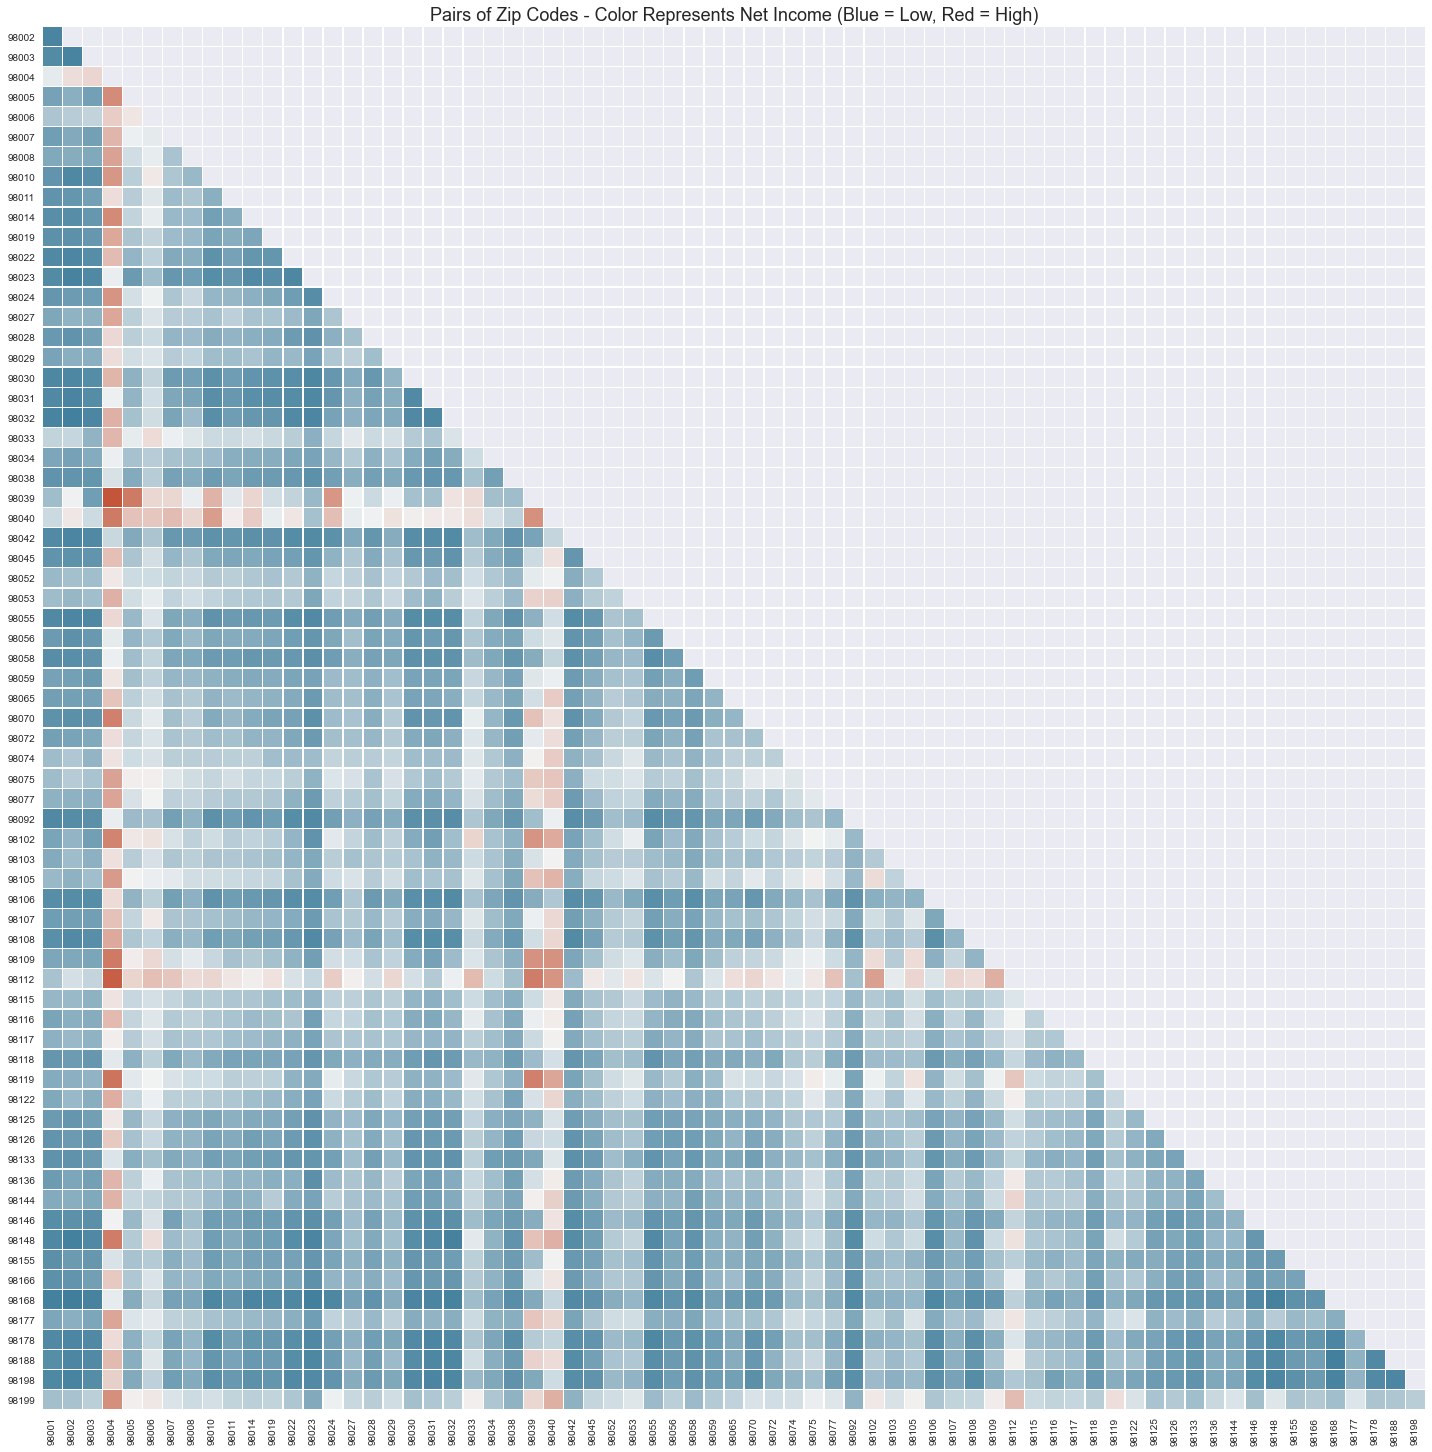

In [44]:
# Pivot Results to Plot
pivot = results_df.pivot(index='zipcode_two', columns='zipcode_one', values='net_income')

# Create Figure
fig = plt.figure(figsize=(20, 25))

# Plot Heatmap
sns.heatmap(pivot, square=True, cmap=cmap, linewidths=0.5, cbar=False)

# Remove Labels
plt.xlabel(None)
plt.ylabel(None)

# Create Title
plt.title('Pairs of Zip Codes - Color Represents Net Income (Blue = Low, Red = High)', size=18)

fig.tight_layout()
plt.show();

#### Observations:
- In the heatmap, I can see some red columns/rows. Those represent the Zip Codes with the Highest Net Income numbers. The Zip Codes are the following: `98004, 98040, 98039 and 98112`.
- The best combination seems to be `98004 and 98039`.

Another way to look at the same data is to sum the Net Income for each Zip Code on every combination where it was present. To explain my approach, I'm going to use an analogy.
> _For example, let's say I'm the coach of a basketball team with ten players, and my goal is to find the best combination of players that will bring the highest score. After testing all combinations (and let's assume that players are robots here and every game was under the same conditions), I realize that the score is high every time Player X is on the field. That's a good indication that Player X might be the cause of High Scores._

Therefore, the same approach to Zip Codes will show the ones with the Highest Net Income Numbers. Moreover, since I am only looking at pairs, that becomes even more significant. Going back to the analogy, it would be like analyzing Basketball Players' performance and seeing that teams with Player X always had high scores.

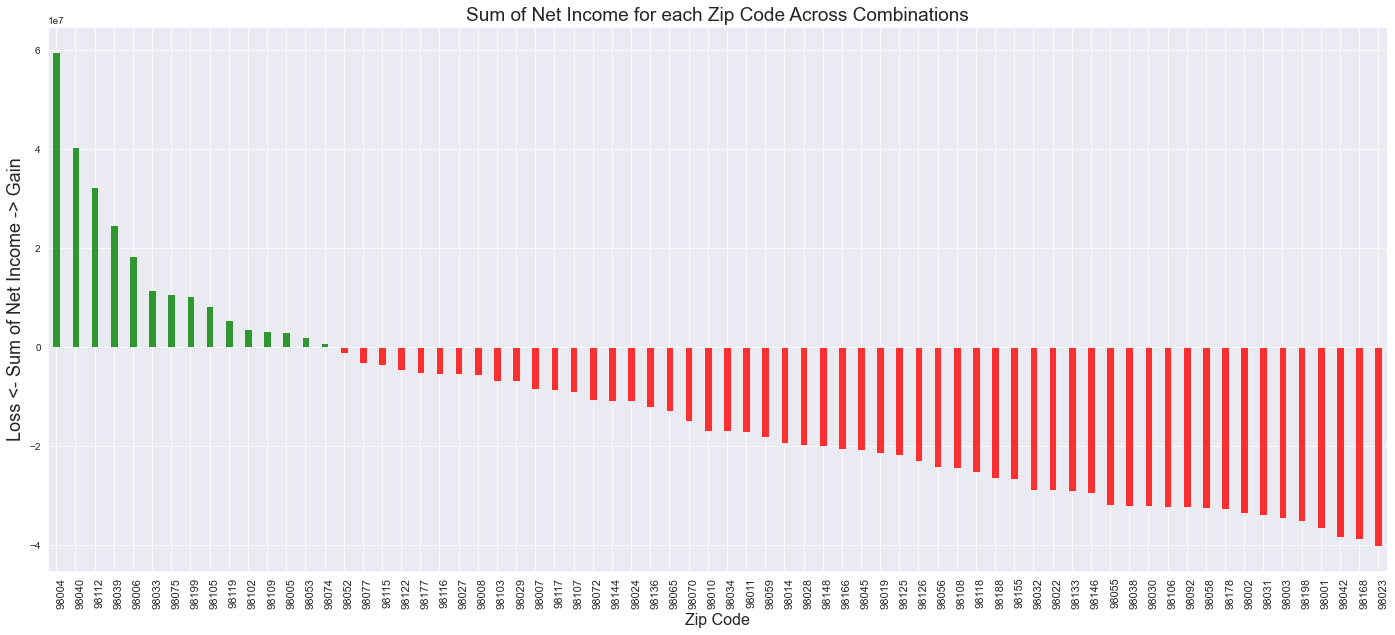

In [45]:
# Zip Code One Sum of Net Income
zip_one_sum = results_df.groupby('zipcode_one').sum()['net_income']
zip_one_sum = zip_one_sum.reset_index()
zip_one_sum.columns = ['zipcode', 'net_income_one']

# Zip Code Two Sum of Net Income
zip_two_sum = results_df.groupby('zipcode_two').sum()['net_income']
zip_two_sum = zip_two_sum.reset_index()
zip_two_sum.columns = ['zipcode', 'net_income_two']

# Combine DataFrames and Sum Net Incomes
zip_net_income = pd.merge(zip_one_sum, zip_two_sum, on='zipcode', how='outer').fillna(0)
zip_net_income['sum'] = zip_net_income['net_income_one'] + zip_net_income['net_income_two']

# Sort Results
zip_net_income = zip_net_income.sort_values('sum', ascending=False).reset_index(drop=True)

# Create list with custom colors
colors = []
for value in zip_net_income['sum']:
    if value > 0:
        colors.append('green')
    else:
        colors.append('red')

# Create Figure
fig = plt.figure(figsize=(24,10))

# Create matplotlib axes and secondary axes
ax = fig.add_subplot(111) 

# Plot
width = 0.4
zip_net_income.plot.bar('zipcode', 'sum', legend=False, width=width, color=colors,
                       ax=ax, position=1, align='edge', alpha=0.8)

# Set Labels
plt.title('Sum of Net Income for each Zip Code Across Combinations', size=19)
ax.set_ylabel('Loss <- Sum of Net Income -> Gain', size=18)
ax.set_xlabel('Zip Code', size=16)
ax.set_xticklabels(zip_net_income['zipcode'], fontsize = 11, ha='left')
plt.show();

#### Observations:
- Green Bars: `98004`, `98040`, `98112`, `98039` and `98006` are the most profitable Zip Codes. 
- Red Bars: `98023`, `98168`, `98042`, `98001`, and `98002` are on the other end of the spectrum.

### 5. Impact of No. of Agents in Net Income in Top 5 Most Profitable Zip Codes <a class="anchor" id="rev_5"></a> 
Previously, I had assumed that the No. of Agents was 10. However, let's see the implication of adding more Agents.
Also, since I have identified the Top 5 Most Profitable Zip Codes, I will limit our dataset to these 5 Zip Codes and create all possible combinations among them.

In [46]:
# Create Empty List to Store Results
results_metrics = []

# Create Combinations of Top 5 Zip Codes
top_5_zip_codes = zip_net_income['zipcode'].head(5).to_list()

# Create All possible combinations
pairs_of_zipcodes = []
for pair_n in range(1,6):
    for pair in combinations(top_5_zip_codes, pair_n):
        pairs_of_zipcodes.append(pair)

# Define Variables
for no_of_agents in range(10, 101, 5):

    # Calculate Average Success Rate
    avg_success_rate = calc_avg_success_rate(assumption_success_rate, 
                                             assumption_std_dev_success_rate, 
                                             no_of_agents)

    # Annual Cost per Agent
    annual_salaries_cost = (annual_salary_per_agent * no_of_agents)

    # Calculate Total Number of Houses listed by the Agency
    total_houses_agency = int(no_of_houses_per_agent * no_of_agents)
    sold_houses_agency = int(total_houses_agency * avg_success_rate)
    sold_houses_above_minimum = int(sold_houses_agency * above_minimum_rate)

    # For Pairs in List of Pairs
    for zipcode_pair in pairs_of_zipcodes:
        
        # Calculate No. of Zip Codes in combination
        len_pair = len(zipcode_pair)

        # Create set with houses from the Zip Code Pair
        zipcode_pair_houses_df = house_market_df[house_market_df['zipcode'].isin(zipcode_pair)]

        # Create DataFrame with Listed Houses
        # Depending on the combination of Zip Codes, it's possible that I end up with fewer Houses Available 
        # than the calculated amount for the agency given the No. of Agents. In this case, then I just
        # pick all the houses in the dataframe.
        if total_houses_agency <= len(zipcode_pair_houses_df):
            selected_houses_idx = np.random.choice(list(zipcode_pair_houses_df.index), total_houses_agency, replace=False)
            listed_houses_df = zipcode_pair_houses_df.loc[selected_houses_idx]
        else:
            total_houses_agency = len(zipcode_pair_houses_df)
            sold_houses_agency = int(total_houses_agency * avg_success_rate)
            sold_houses_above_minimum = int(sold_houses_agency * above_minimum_rate)
            listed_houses_df = zipcode_pair_houses_df.copy()

        # Randomly select Sold Houses
        sold_houses_idx = np.random.choice(list(listed_houses_df.index), sold_houses_agency, replace=False)
        sold_houses_df = listed_houses_df.loc[sold_houses_idx]

        # Houses Sold Above Minimum - First Rows
        above_minimum_houses_df = sold_houses_df[:sold_houses_above_minimum]
        not_above_minimum_houses_df = sold_houses_df[sold_houses_above_minimum:]

        # Calculate Revenue and Gross Income
        revenue_not_above_minimum = not_above_minimum_houses_df['price'].sum()
        revenue_above_minimum = above_minimum_houses_df['price'].sum()
        gross_income = ((revenue_not_above_minimum * minimum_commission_rate) + 
                        (revenue_above_minimum * above_minimum_commission_rate))

        # Calculate Net Income
        # Remove Commission Shared with Agents
        agents_commission = agent_commission_rate * gross_income
        net_income = gross_income - agents_commission
        # Remove Salaries and Other Costs
        net_income = net_income - annual_salaries_cost
        
        # Append Metrics
        results_metrics.append([no_of_agents, avg_success_rate, annual_salaries_cost, agents_commission,
                                total_houses_agency, sold_houses_agency, sold_houses_above_minimum, 
                                zipcode_pair, net_income, gross_income, len_pair])

In [47]:
# Create DataFrame
results_metrics_df = pd.DataFrame(results_metrics)

# Rename Columns
results_metrics_df.columns = ['no_of_agents', 'succes_rate_per_agent', 'annual_salaries_cost', 
                              'agents_commission', 'total_houses_agency', 'total_sold_houses', 
                              'sold_houses_above_minimum', 'zipcode_comb', 'net_income', 'gross_income',
                              'no_of_zipcodes']

# Calculate Net Income per Agent
results_metrics_df['net_income_per_agent'] = (results_metrics_df['net_income'] 
                                              / results_metrics_df['no_of_agents'])

# Calculate Net Income per Sold House
results_metrics_df['net_income_per_sold_house'] = (results_metrics_df['net_income'] 
                                                   / results_metrics_df['total_sold_houses'])

# Calculate Profit Margin
results_metrics_df['profit_margin'] = (results_metrics_df['net_income'] 
                                       / results_metrics_df['gross_income'])

# Calculate Return on Investment
results_metrics_df['roi'] = (results_metrics_df['net_income'] 
                             / results_metrics_df['annual_salaries_cost']) - 1

### 6. Analyze results in different scenarios <a class="anchor" id="rev_6"></a>
Now that I have run all the simulations, it's time to analyze the results. However, it will be hard to pick the best option for the Agency since it depends on various constraints that I don't know. 

For example, they might tell me that they have X amount in cash to invest in the business, which would drive my analysis towards limiting `annual_salaries_cost` based on how much money they have while maximizing `net_income`.

Others might start thinking about diversification of their portfolio of listings, which would make me increase the No. of Zip Codes in their portfolio to like at least 3.

The examples are infinite. However, since I don't have all that information, I'm going to create different scenarios.

#### Scenario 1: No Funding Limit, Maximize Return on Investment, High Risk.

In [48]:
scenario_1 = results_metrics_df.sort_values('roi', ascending=False).head()
scenario_1

no_of_agents  succes_rate_per_agent  annual_salaries_cost  \
93             25               0.293635               3814125   
124            30               0.270031               4576950   
94             25               0.293635               3814125   
31             15               0.261929               2288475   
95             25               0.293635               3814125   

     agents_commission  total_houses_agency  total_sold_houses  \
93          6368032.60                  825                242   
124         7081038.60                  990                267   
94          5793343.76                  825                242   
31          3314371.80                  495                129   
95          5322388.22                  825                242   

     sold_houses_above_minimum zipcode_comb  net_income  gross_income  \
93                          24     (98004,)  5737923.90   15920081.50   
124                         26     (98004,)  6044607.90   17702596.50   
94                          24     (98040,)  4875890.64   14483359.40   
31                          12     (98004,)  2683082.70    8285929.50   
95                          24     (98112,)  4169457.33   13305970.55   

     no_of_zipcodes  net_income_per_agent  net_income_per_sold_house  \
93                1           229516.9560               23710.429339   
124               1           201486.9300               22638.980899   
94                1           195035.6256               20148.308430   
31                1           178872.1800               20799.090698   
95                1           166778.2932               17229.162521   

     profit_margin       roi  
93        0.360421  0.504388  
124       0.341453  0.320663  
94        0.336655  0.278377  
31        0.323812  0.172433  
95        0.313352  0.093162

- `98004 or 98040` seem to be the best options. One thing to consider would be the No. of Agents and Total Listings because it's rational to think that more agents will sell more houses. However, at the same time, that means more people to manage and maybe other unforeseen costs associated with that.
- The best option requires 3.8 Million dollars in capital to fund, which might be too much for some investors.
- I like the `net_income_per_agent`, where I maximize profit by minimizing the No. of Agents, which would lead me to recommend `98004` with 25 agents.
- Based on the results, the best Return you can get is 50%, which might be too low for some investors, given the risk and the necessary capital to start the business.

#### Scenario 2: I have Three Million Dollars for the year, and I'm risk moderate.

In [49]:
# Define Cash available
cash_available = 3000000

# Keep only combinations with more than one Zip Codes (that's questionable)
scenario_2 = results_metrics_df[results_metrics_df['no_of_zipcodes'] > 1]

# Ensure that Annual Salaries Cost is Less than cash available
scenario_2 = scenario_2[scenario_2['annual_salaries_cost'] <= cash_available]

# Keep only profitable simulations
scenario_2 = scenario_2[scenario_2['profit_margin'] > 0]

scenario_2.sort_values('profit_margin', ascending=False)

no_of_agents  succes_rate_per_agent  annual_salaries_cost  \
7             10                0.25143               1525650   
21            10                0.25143               1525650   
10            10                0.25143               1525650   
18            10                0.25143               1525650   
16            10                0.25143               1525650   
17            10                0.25143               1525650   
12            10                0.25143               1525650   

    agents_commission  total_houses_agency  total_sold_houses  \
7          1260740.00                  167                 41   
21         1161767.00                  167                 41   
10         1142350.00                  167                 41   
18         1096707.00                  167                 41   
16         1061006.00                  167                 41   
17         1030100.42                  167                 41   
12         1022285.00                  167                 41   

    sold_houses_above_minimum           zipcode_comb  net_income  \
7                           4         (98004, 98039)   365460.00   
21                          4  (98040, 98112, 98039)   217000.50   
10                          4         (98040, 98039)   187875.00   
18                          4  (98004, 98112, 98039)   119410.50   
16                          4  (98004, 98040, 98039)    65859.00   
17                          4  (98004, 98040, 98006)    19500.63   
12                          4         (98112, 98039)     7777.50   

    gross_income  no_of_zipcodes  net_income_per_agent  \
7     3151850.00               2             36546.000   
21    2904417.50               3             21700.050   
10    2855875.00               2             18787.500   
18    2741767.50               3             11941.050   
16    2652515.00               3              6585.900   
17    2575251.05               3              1950.063   
12    2555712.50               2               777.750   

    net_income_per_sold_house  profit_margin       roi  
7                 8913.658537       0.115951 -0.760456  
21                5292.695122       0.074714 -0.857765  
10                4582.317073       0.065785 -0.876856  
18                2912.451220       0.043552 -0.921731  
16                1606.317073       0.024829 -0.956832  
17                 475.625122       0.007572 -0.987218  
12                 189.695122       0.003043 -0.994902

- `98004 and 98039` is the best combination.
- `98040, 98112, 98039` seems to be the second-best combination. 
- However, `roi` is negative. This makes me think that the current Business Model is too capital-intensive for the given scenario.

#### Scenario 3: I already have a Team of 20 Agents, and I want to be as cost-efficient as possible.

In [50]:
# Filter for Simulations with 20 agents
scenario_3 = results_metrics_df[results_metrics_df['no_of_agents'] == 20]

scenario_3.sort_values('net_income_per_agent', ascending=False).head()

no_of_agents  succes_rate_per_agent  annual_salaries_cost  \
62            20               0.233318               3051300   
63            20               0.233318               3051300   
64            20               0.233318               3051300   
65            20               0.233318               3051300   
72            20               0.233318               3051300   

    agents_commission  total_houses_agency  total_sold_houses  \
62         4061132.60                  660                153   
63         3689610.76                  660                153   
64         3543414.46                  660                153   
65         1471410.00                  167                 38   
72         1178358.52                  167                 38   

    sold_houses_above_minimum    zipcode_comb  net_income  gross_income  \
62                         15        (98004,)  3040398.90   10152831.50   
63                         15        (98040,)  2483116.14    9224026.90   
64                         15        (98112,)  2263821.69    8858536.15   
65                          3        (98039,)  -844185.00    3678525.00   
72                          3  (98040, 98039) -1283762.22    2945896.30   

    no_of_zipcodes  net_income_per_agent  net_income_per_sold_house  \
62               1           152019.9450               19871.888235   
63               1           124155.8070               16229.517255   
64               1           113191.0845               14796.220196   
65               1           -42209.2500              -22215.394737   
72               2           -64188.1110              -33783.216316   

    profit_margin       roi  
62       0.299463 -0.003573  
63       0.269201 -0.186210  
64       0.255553 -0.258080  
65      -0.229490 -1.276664  
72      -0.435780 -1.420726

- `98004` will provide the highest `profit_margin`. However, there's a high risk to be exposed to only one Zip Code, and `roi` is practically zero.

### 7. Conclusion<a class="anchor" id="rev_7"></a>
These were just a few examples of how I could utilize the data to estimate Revenue. The model will be driven by the given constraints and assumptions, of course, so it would be better to work directly with the stakeholder to fine-tune my numbers. My lack of knowledge about the industry also affects the outcome I see above. The business model seems to be flawed.

However, the model is created. It's just a matter of changing or making more assumptions to get to a more 'realistic' model.

**[Go back to Table of Contents](#toc)**

# Modeling<a class="anchor" id="mol"></a>
## Feature Transformation<a class="anchor" id="transf"></a>
Before fitting a regression line to the dataset, it's crucial to review features and ensure that they're in good shape for that.

### 1. Null Values and Boolean Fields<a class="anchor" id="transf_1"></a>
Some fields have null data, which are valuable data points, since the absence of a basement, for example, can have an impact on price. Therefore, I'm going to create boolean fields for `waterfront`, `view`, `basement`, and `renovated`.

In [51]:
# Create a DataFrame for modeling (I want to keep df as the original DataFrame in case I need to come back to it)
model_df = df.copy()

### `waterfront`

In [52]:
# Check Unique Values for Waterfront
model_df['waterfront'].unique()

array([nan,  0.,  1.])

Since the field is already a boolean field, the only thing I need to do is replace `NaN` with zero.

In [53]:
model_df['waterfront'].fillna(0, inplace=True)
model_df['waterfront'].unique()

array([0., 1.])

### `view`

In [54]:
# Check Unique Values for View
model_df['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

Since the field represents the No. of Views, then I'm going to assume that `NaN` is same as no view or zero.

In [55]:
model_df['view'].fillna(0, inplace=True)
model_df['view'].unique()

array([0., 3., 4., 2., 1.])

Now I'm creating the boolean field `has_view`

In [56]:
model_df['has_view'] = 0
model_df.loc[model_df['view'] > 0, 'has_view'] = 1
model_df['has_view'].unique()

array([0, 1])

### `basement`

In [57]:
# Check whether there are Nulls in 'sqft_basement'
sum(model_df['sqft_basement'].isnull())

0

In this case, I'm assuming that if the value is null is because there's no basement or `sqft_basement` is zero.

In [58]:
model_df['sqft_basement'].fillna(0, inplace=True)

I also noticed that the data type is float, but that might not be necessary. I'm going to confirm that and convert to integer if makes sense.

In [59]:
# Last two characters of every row
model_df['sqft_basement'].astype(str).str[-2:].unique()

array(['.0'], dtype=object)

It's safe to convert to integer, since the decimal is always zero

In [60]:
model_df['sqft_basement'] = model_df['sqft_basement'].astype(int)

Now I'm going to create the boolean field `has_basement`

In [61]:
model_df['has_basement'] = 0
model_df.loc[model_df['sqft_basement'] > 0, 'has_basement'] = 1
model_df['has_basement'].unique()

array([0, 1])

### `renovated`

In [62]:
# Check whether there are Nulls in 'yr_renovated'
sum(model_df['yr_renovated'].isnull())

3842

Following the same approach done before, if null then there was not renovation and so the value should be zero. Also, convert the field to integer.

In [63]:
model_df['yr_renovated'].fillna(0, inplace=True)
model_df['yr_renovated'] = model_df['yr_renovated'].astype(int)

Now I'm going to create the boolean field `has_renovation`

In [64]:
model_df['has_renovation'] = 0
model_df.loc[model_df['yr_renovated'] > 0, 'has_renovation'] = 1
model_df['has_renovation'].unique()

array([0, 1])

**[Go back to Table of Contents](#toc)**

### 2. Create new features/feature engineering<a class="anchor" id="transf_2"></a>
Given the data available, it's possible to derive various fields that might help with `price` prediction.

### `age`

Since I have the date on which the house was sold + Year in which it was renovated or built, I can calculate the house's age.

In [65]:
# Calculate 'age' in No. of Years
model_df['age'] = model_df['date'].dt.year - model_df['yr_built']

# See Unique Values
model_df['age'].sort_values().unique()

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

Interesting to see -1. That would indicate that the house was sold before it was actually built.

In [66]:
# How much of our dataset does -1 represent?
len(model_df[model_df['age'] == -1]) / len(model_df)

0.0005556327267676066

0.055 % of houses were bought before actually built. Not very representative.

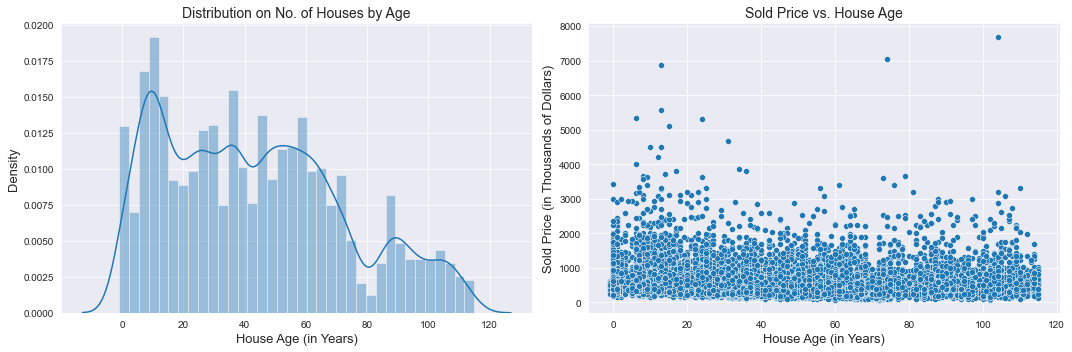

In [67]:
# Create Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Plot histogram
sns.distplot(model_df['age'], ax=axes[0])
axes[0].set_title('Distribution on No. of Houses by Age', size=14)
axes[0].set_ylabel('Density', size=13)
axes[0].set_xlabel('House Age (in Years)', size=13)

# Scatter Plot of Prices by Coordinates
sns.scatterplot(model_df['age'], model_df['price'] / 1000, ax=axes[1])
axes[1].set_title('Sold Price vs. House Age', size=14)
axes[1].set_ylabel('Sold Price (in Thousands of Dollars)', size=13)
axes[1].set_xlabel('House Age (in Years)', size=13)

fig.tight_layout()
plt.show();

In [68]:
# Some stats on 'age'
print('Mean Age:', model_df['age'].mean().round(2))
print('Median Age:', model_df['age'].median().round(2))
print('Mean Built Year:', int(model_df['yr_built'].mean()))
print('Median Built Year:', int(model_df['yr_built'].median()))

Mean Age: 43.32
Median Age: 40.0
Mean Built Year: 1970
Median Built Year: 1975


#### Conclusions:
- Mean/Median Age of Houses are ~40 years (built in the 70s).
- Price doesn't vary much by age. However, there's a subtle decline as age progresses, making it possibly a useful datapoint to predict the price.

In [69]:
# Calculate 'age' in No. of Years
model_df['years_since_renovation'] = model_df['date'].dt.year - model_df['yr_renovated'].astype(int)

# If there was no renovation then just leave it as zero
model_df.loc[model_df['yr_renovated'] == 0, 'years_since_renovation'] = 0

# See Unique Values
model_df['years_since_renovation'].sort_values().unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 69, 70,
       74, 80])

**[Go back to Table of Contents](#toc)**

### 3. Reduce bias in model towards Zip Codes with more records by oversampling<a class="anchor" id="transf_3"></a>
I'm afraid that because I have more samples of certain Zip Codes, the model will perform poorly in areas with fewer samples. Therefore, I think it's good to use the Bootstrap method to create 'more records' and have a balanced dataset.

In [70]:
# Calculate Zip Code with the highest count of Houses
model_df.groupby('zipcode').count()['price'].sort_values(ascending=False).head()

zipcode
98103    602
98038    589
98115    583
98052    574
98117    553
Name: price, dtype: int64

In [71]:
# Total No. of Records by Zip Code
total_n = 602

# Loop through Zip Codes
for zipcode in model_df['zipcode'].unique():
    
    # Create Zip Code Dataframe
    zipcode_df = model_df[model_df['zipcode'] == zipcode]

    # Calculate No. of Records and difference from goal
    zipcode_len = len(zipcode_df)
    diff_n = total_n - zipcode_len
    
    # If difference is greater than zero, then I need to perform sampling
    if diff_n > 0:
        random_idx = np.random.choice(list(zipcode_df.index), diff_n, replace=True)
        
        # New Samples
        new_samples = zipcode_df.loc[random_idx]

        # Add new samples to dataframe
        model_df = pd.concat([model_df, new_samples])

In [72]:
# Check result
model_df.groupby('zipcode').count()['price'].sort_values().head()

zipcode
98001    602
98074    602
98075    602
98077    602
98092    602
Name: price, dtype: int64

Everything looks good!

In [73]:
# I need to reset the index though because now there are multiple rows with the same index
model_df = model_df.reset_index(drop=True)

**[Go back to Table of Contents](#toc)**

### 4. One-Hot Encoding of Features<a class="anchor" id="transf_4"></a>
### `zipcode`

In [74]:
# Drop unnecessary columns
model_df = model_df.drop(['id', 'date'], axis=1)

# Create columns
zipcodes_df = pd.get_dummies(model_df['zipcode'], prefix='zipcode', drop_first=True)

# Concatenate
model_df = pd.concat([model_df.drop('zipcode', axis=1), zipcodes_df], axis=1)

### Analyze whether I should do one-hot encoding of a few other columns
I'm not confident if `bedrooms`, `bathrooms`, `floors`, `view`, `condition` and `grade` should be considered continuous variables in my model. Therefore, I'm going to look at some boxplots to see if they indicate some linear relationship.

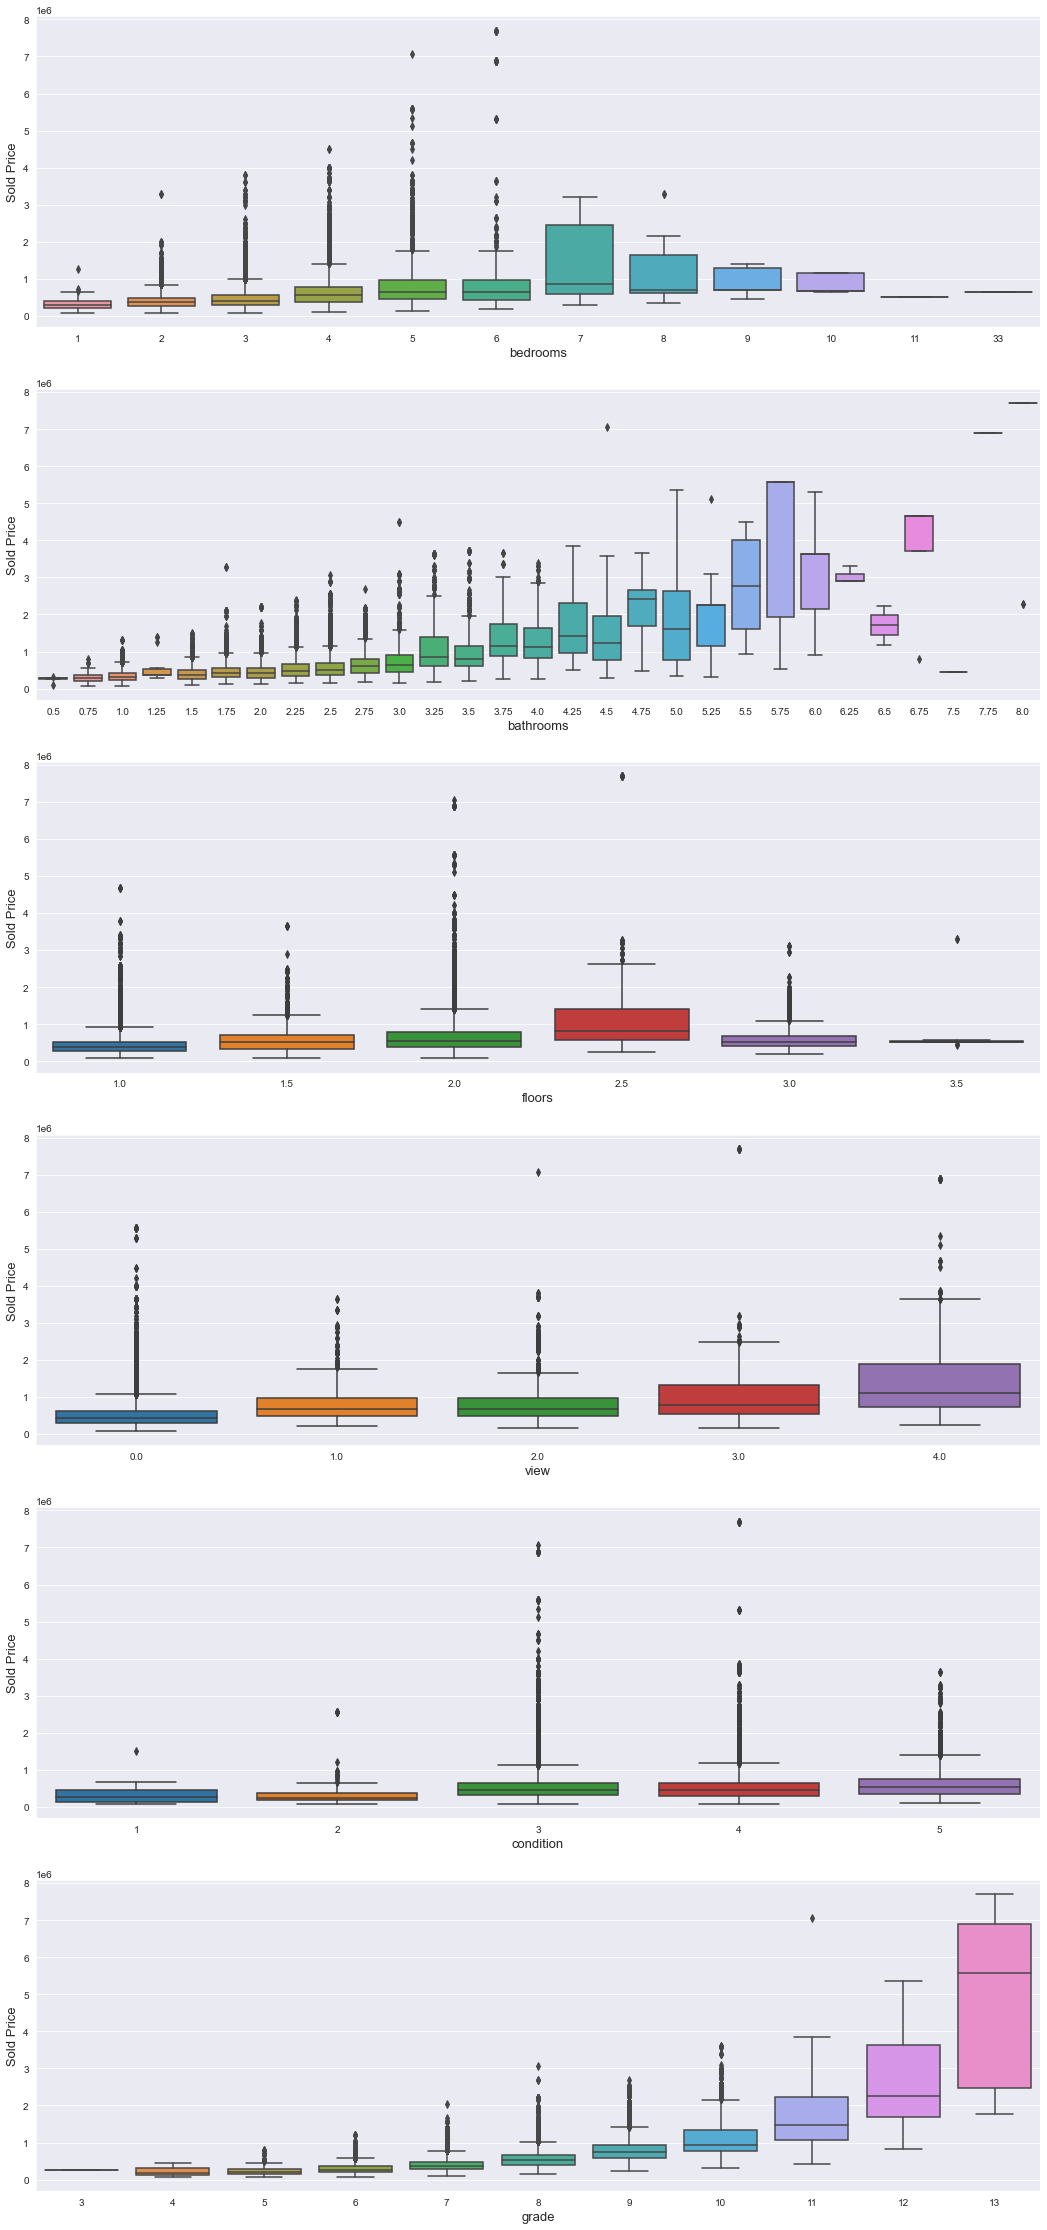

In [75]:
# Create Figure and Subplots
fig, axes = plt.subplots(6, 1, figsize=(18,40))

# Loop through fields
for idx, field in enumerate(['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']):

    # Boxplot
    sns.boxplot(x=field, y="price", data=model_df, ax=axes[idx])
    
    # Y and X labels
    axes[idx].set_ylabel('Sold Price', size=13)
    axes[idx].set_xlabel(field, size=13)

plt.show();

#### Observations:
- Seem to follow a linear relationship with price: `bedrooms`, `bathrooms` and `grade`.
- Don't seem to follow a strong linear relationship with price: `floors`, `view` and `condition`.

Let's take a look at the correlations again.

In [76]:
model_df[['price', 'bedrooms', 'bathrooms', 'grade', 'floors', 'view', 'condition']].corr()[['price']]

price
price      1.000000
bedrooms   0.320778
bathrooms  0.558954
grade      0.674183
floors     0.263097
view       0.350460
condition  0.041857

Based on the numbers, only `grade` and `bathrooms` have higher correlations than others. I'm going to keep all of those in the model but create dummy columns for `floors`, `view`, and `condition` since I don't see a linear relationship.

### One-hot encoding of `floors`, `view` and `condition`

In [77]:
# Create One-hot encoding
model_df = pd.get_dummies(data=model_df, columns=['floors', 'view', 'condition'], drop_first=True)

Rename a few columns to avoid problems with modeling

In [78]:
# Loop through columns
for col in list(model_df.columns):

    # See if can find '.' in column name
    if '.' in col:
    
        # Rename column
        new_col = col.replace('.','_point_')
        model_df.rename(columns = {col:new_col}, inplace = True) 

**[Go back to Table of Contents](#toc)**

### 5. Percentage of Zero/Null in Variables<a class="anchor" id="transf_5"></a>
If continuous columns have mostly no data, most likely, it's going to be useless for the model. Therefore, I'm going to identify those and remove them.

In [79]:
# Define Continuous Variables to look at
continuous_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'sqft_above', 
                   'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 
                   'downtown_distance', 'years_since_renovation']

# Create DataFrame
continuous_df = model_df[continuous_cols]

# Check for No. of Records with zeros for each column
# Create empty list to store results
results = []

# Loop through columns and calculate percentage of zeros
for col in continuous_cols:
    zero_perc =  len(model_df[model_df[col] == 0]) / len(model_df)

    # Append result only if the percentage is different than zero
    if zero_perc != 0:
        results.append([col, zero_perc])
    
# Create DataFrame using results
zero_perc_df = pd.DataFrame(results)
zero_perc_df.columns = ['variable', 'perc_of_zeros']
zero_perc_df.sort_values('perc_of_zeros', ascending=False)

variable  perc_of_zeros
2  years_since_renovation       0.965164
0           sqft_basement       0.616825
1                     age       0.019435

A bit upsetting to remove the fields just created but I have to do what's right.

In [80]:
# Update model_df and continous_cols
cols_to_remove = ['years_since_renovation', 'sqft_basement']
model_df = model_df.drop(cols_to_remove, axis=1)
[continuous_cols.remove(i) for i in cols_to_remove]

[None, None]

In [81]:
# update continous_df
continuous_df = continuous_df[continuous_cols]

**[Go back to Table of Contents](#toc)**

### 6. Check for Normality of continous variables <a class="anchor" id="transf_6"></a>
A Linear Regression model works better with normally distributed features. Therefore, it's good to look at them and see if any other steps need to be taken to normalize these features.

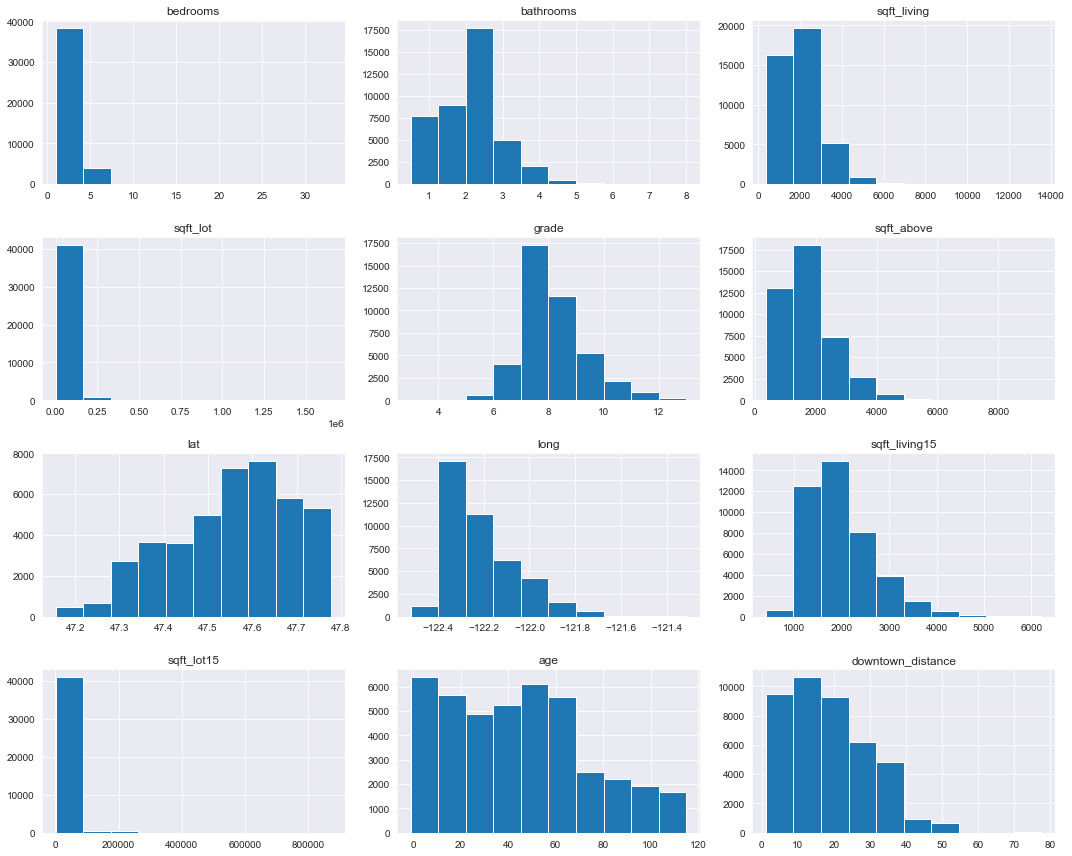

In [82]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,12))

# Go through each column
for idx, column in enumerate(continuous_df.columns):

    # Calculate chart position
    col_n = idx % 3
    row_n = idx // 3
    
    # Plot Histogram and Title
    axes[row_n][col_n].hist(continuous_df[column])
    axes[row_n][col_n].set_title(column)

fig.tight_layout()
plt.show();    

Most don't have a bell-shape, which makes me think that I should normalize them. However, I'm afraid that I might lose interpretability by doing that. 

**[Go back to Table of Contents](#toc)**

### 7. Feature Scaling - Z-Score<a class="anchor" id="transf_7"></a>
I noticed that they vary a lot in magnitude, which will have a negative impact on model interpretability. Therefore, what I can do instead is to scale them so coefficients are comparable.

### Apply Z-Score to Continous Values

In [84]:
# Keep copy of original data before applying Z-Score: for future use, it will help me to understand the impact
# of the variables, before normalization
model_df_pre_norm = model_df.copy()

# Replace Columns with Z-Scores
for col in continuous_df.columns:
    model_df[col] = (model_df[col] - np.mean(model_df[col])) / np.std(model_df[col])

**[Go back to Table of Contents](#toc)**

## Model Training <a class="anchor" id="train"></a>
With features in good shape, it's time to train and build a baseline model. Then, it's an iterative process of looking at results, fixing a few things here and there, trying to increase accuracy while keeping it interpretable and able to generalize predictions (Bias-variance tradeoff).

Moreover, the goal here is to create a model to understand the market and which features are most/least valuable. It's an inference problem, where I'm trying to infer from the model coefficients how the market behaves. 

This mindset will guide me through this process.

In [85]:
# Define Predictors and Outcome
x_cols = list(model_df.columns.drop('price'))
outcome = 'price'

In [86]:
# Define X and y
X = model_df.drop('price', axis=1)
y = model_df['price']

### Build a Baseline Model using Cross Validation<a class="anchor" id="baseline"></a>
First, I'm going to create a Baseline model by merely fitting the best line.

In [87]:
# Create List to store results from models as I change them
models_performance = []

In [88]:
# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X, y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['baseline', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8224386740340659
Neg Mean Squared Error: -34520872368.943665


#### Notes:
- Pretty high R-Squared, which is good.
- However, MSE is High as well.

### Fit OLS Model
For interpretability, I'm going to fit the ols model with the same data points to look at the summary report.

In [89]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1984.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:39:09   Log-Likelihood:            -5.7084e+05
No. Observations:               42140   AIC:                         1.142e+06
Df Residuals:                   42040   BIC:                         1.143e+06
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.653e+07   3.83e+06    -12.138      0.000    -5.4e+07    -3.9e+07
bedrooms          -3.851e+04   1189.931    -32.361      0.000   -4.08e+04   -3.62e+04
bathrooms           3.04e+04   1719.709     17.677      0.000     2.7e+04    3.38e+04
sqft_living        1.901e+05   3765.671     50.476      0.000    1.83e+05    1.97e+05
sqft_lot           1.177e+04   1367.245      8.612      0.000    9094.983    1.45e+04
waterfront         4.288e+05   1.25e+04     34.293      0.000    4.04e+05    4.53e+05
grade               6.92e+04   1809.370     38.244      0.000    6.57e+04    7.27e+04
sqft_above         4.838e+04   3788.561     12.770      0.000     4.1e+04    5.58e+04
yr_built           2.389e+04   1945.467     12.281      0.000    2.01e+04    2.77e+04
yr_renovated       1725.0750    306.785      5.623      0.000    1123.770    2326.380
lat                6147.3516   7613.132      0.807      0.419   -8774.542    2.11e+04
long               6.637e+04   7468.002      8.887      0.000    5.17e+04     8.1e+04
sqft_living15     -5110.5487   1615.879     -3.163      0.002   -8277.704   -1943.393
sqft_lot15        -1.198e+04   1409.390     -8.498      0.000   -1.47e+04   -9215.236
downtown_distance  -8.92e+04   6752.115    -13.211      0.000   -1.02e+05    -7.6e+04
has_view           1.289e+05   3161.267     40.778      0.000    1.23e+05    1.35e+05
has_basement      -4.764e+04   3408.607    -13.976      0.000   -5.43e+04    -4.1e+04
has_renovation    -3.426e+06   6.12e+05     -5.596      0.000   -4.63e+06   -2.23e+06
age                7.269e+05   5.73e+04     12.693      0.000    6.15e+05    8.39e+05
zipcode_98002      8232.5079    1.1e+04      0.749      0.454   -1.33e+04    2.98e+04
zipcode_98003     -4999.2402   1.08e+04     -0.462      0.644   -2.62e+04    1.62e+04
zipcode_98004      5.145e+05   2.18e+04     23.576      0.000    4.72e+05    5.57e+05
zipcode_98005      6.203e+04   2.17e+04      2.854      0.004    1.94e+04    1.05e+05
zipcode_98006      2.925e+04   2.02e+04      1.446      0.148   -1.04e+04    6.89e+04
zipcode_98007      1.862e+04   2.18e+04      0.855      0.392   -2.41e+04    6.13e+04
zipcode_98008      4.229e+04    2.2e+04      1.923      0.055    -823.260    8.54e+04
zipcode_98010     -1000.8858   1.51e+04     -0.066      0.947   -3.06e+04    2.86e+04
zipcode_98011     -3.915e+04   2.56e+04     -1.530      0.126   -8.93e+04     1.1e+04
zipcode_98014     -6.337e+04    2.6e+04     -2.437      0.015   -1.14e+05   -1.24e+04
zipcode_98019     -6.953e+04   2.69e+04     -2.589      0.010   -1.22e+05   -1.69e+04
zipcode_98022      1.639e+04   1.48e+04      1.104      0.270   -1.27e+04    4.55e+04
zipcode_98023      8225.1250   1.16e+04      0.711      0.477   -1.45e+04    3.09e+04
zipcode_98024     -2.334e+04   2.24e+04     -1.043      0.297   -6.72e+04

#### Observations:
- Relatively High R-Squared
- Given that some features have a p-value > 0.05, there's some cleaning to be done
- Coefficients are hard to interpret, probably should transform `price`
- Very High Jarque-Bera meaning that the distribution of errors is not normal

**[Go back to Table of Contents](#toc)**

### Remove features where p-value > 0.05 <a class="anchor" id="model_1"></a>

In [90]:
# Remove features which do not appear to be statistically relevant
to_exclude = list(model.pvalues[model.pvalues > 0.05].index)

# Remove Columns
for col in x_cols:
    if col in to_exclude:
        x_cols.remove(col)
predictors = '+'.join(x_cols)

In [91]:
# Refit the model
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2503.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:39:10   Log-Likelihood:            -5.7096e+05
No. Observations:               42140   AIC:                         1.142e+06
Df Residuals:                   42061   BIC:                         1.143e+06
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.635e+07   3.84e+06    -12.076      0.000   -5.39e+07   -3.88e+07
bedrooms          -3.786e+04   1186.280    -31.911      0.000   -4.02e+04   -3.55e+04
bathrooms          3.048e+04   1721.028     17.709      0.000    2.71e+04    3.39e+04
sqft_living        1.897e+05   3767.725     50.347      0.000    1.82e+05    1.97e+05
sqft_lot           1.153e+04   1364.780      8.445      0.000    8851.211    1.42e+04
waterfront         4.298e+05   1.25e+04     34.319      0.000    4.05e+05    4.54e+05
grade              7.099e+04   1798.472     39.472      0.000    6.75e+04    7.45e+04
sqft_above         4.757e+04   3786.404     12.563      0.000    4.01e+04     5.5e+04
yr_built           2.381e+04   1948.108     12.223      0.000       2e+04    2.76e+04
yr_renovated       1770.3579    307.336      5.760      0.000    1167.974    2372.742
long               5.994e+04   2451.044     24.455      0.000    5.51e+04    6.47e+04
sqft_living15     -5314.2000   1585.023     -3.353      0.001   -8420.878   -2207.522
sqft_lot15        -1.207e+04   1405.130     -8.591      0.000   -1.48e+04   -9316.718
downtown_distance -9.351e+04   2400.885    -38.949      0.000   -9.82e+04   -8.88e+04
has_view           1.296e+05   3148.054     41.182      0.000    1.23e+05    1.36e+05
has_basement      -4.799e+04   3407.880    -14.083      0.000   -5.47e+04   -4.13e+04
has_renovation    -3.516e+06   6.13e+05     -5.732      0.000   -4.72e+06   -2.31e+06
age                7.249e+05   5.73e+04     12.640      0.000    6.12e+05    8.37e+05
zipcode_98003       -1.9e+04   8747.634     -2.172      0.030   -3.61e+04   -1858.463
zipcode_98004      5.088e+05   8188.200     62.144      0.000    4.93e+05    5.25e+05
zipcode_98005      5.849e+04   8148.719      7.178      0.000    4.25e+04    7.45e+04
zipcode_98007      1.711e+04   8087.243      2.116      0.034    1257.761     3.3e+04
zipcode_98010      2760.6588   8160.534      0.338      0.735   -1.32e+04    1.88e+04
zipcode_98014     -3.832e+04   8616.266     -4.447      0.000   -5.52e+04   -2.14e+04
zipcode_98019       -4.7e+04   8193.789     -5.736      0.000   -6.31e+04   -3.09e+04
zipcode_98023     -8018.6424   9230.626     -0.869      0.385   -2.61e+04    1.01e+04
zipcode_98027     -1.428e+04   8033.443     -1.777      0.076      -3e+04    1467.305
zipcode_98029      2.212e+04   8228.592      2.688      0.007    5992.150    3.82e+04
zipcode_98030     -7.905e+04   7937.620     -9.959      0.000   -9.46e+04   -6.35e+04
zipcode_98031     -9.842e+04   7836.199    -12.560      0.000   -1.14e+05   -8.31e+04
zipcode_98032     -5.326e+04   8117.775     -6.561      0.000   -6.92e+04   -3.74e+04
zipcode_98033      1.512e+05   7960.227     19.000      0.000    1.36e+05    1.67e+05
zipcode_98038     -6.254e+04   8035.308     -7.783      0.000   -7.83e+04

#### Observations:
- Pretty much the same R-Squared
- 21 features were removed
- Still pretty high Jarque-Bera

Take the same features to do cross-validation and confirm the outputs.

In [92]:
# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X[x_cols], y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X[x_cols], y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['first_remove_p_values', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8216611345469733
Neg Mean Squared Error: -34670493581.882706


**[Go back to Table of Contents](#toc)**

### Create a function to plot a QQ Plot (to check for Normality) and Scatter Plot of Residuals (to check for Homoscedasticity) <a class="anchor" id="model_2"></a>
- With the Q-Q plot, I can confirm whether residuals are normally distributed: if residuals don't fit the straight line, then it suggests that they follow a non-normal distribution.
- With the Scatter Plot, I can check whether residuals' variability is equal across values of the independent variable. If I see a cone-like shape, it suggests that the dependent variable is unequal across the predictors' range of values.

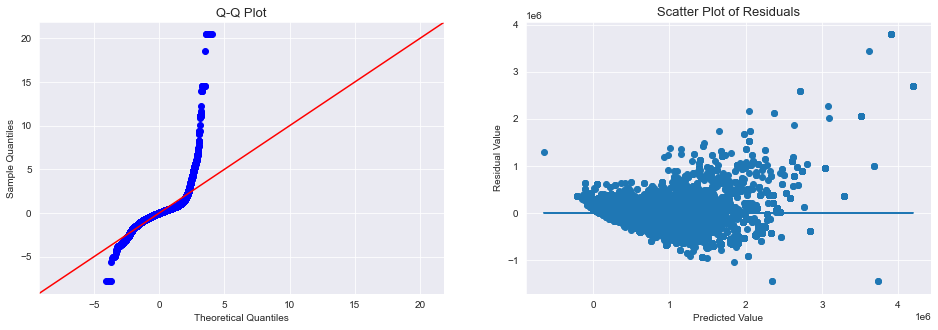

In [93]:
def model_evaluation(model, df):
    """
    Function takes a linear regression model and data. Then generates two plots: Q-Q Plot 
    and a Scatter Plot of Residuals.
    - With the Q-Q Plot it's possible to see whether residuals are normally distributed.
    - With the Scatter Plot it's possible to confirm that the variability of residuals is the same
      across different values of the independente variable

    Args:
      model(statsmodels.regression.linear_model): Statsmodels Linear Regression Trained Model
      df(pandas.DataFrame): Pandas DataFrame with datapoints of the Trained model

    Returns:
      Two Plots: Q-Q Plot and Scatter Plot of Residuals.
    """
    # Create Figure and Subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

    # QQ Plot - Normality
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax1)
    ax1.set_title('Q-Q Plot', size=13)
    
    # Scatter Plot - Homoscedasticity
    ax2.scatter(model.predict(df[x_cols]), model.resid)
    ax2.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Residual Value')
    ax2.set_title('Scatter Plot of Residuals', size=13)
    plt.show();
    
# Plot
model_evaluation(model, model_df)

#### Observations:
- Q-Q Plot: Clearly I can see that residuals are not normally distributed in extreme values. Possibly some work needs to be done on them, maybe those are outliers.
- Scatter Plot: It's possible to see Heterocedasticity, the variability is not the same across different values. It's easier to see that residuals increase variability as the Predicted value increases.

**[Go back to Table of Contents](#toc)**

### Work on these extreme values and remove outliers <a class="anchor" id="model_3"></a>
Outliers are making the model to perform poorly on extremes, so I'm going to investigate them and remove some if appropriate.

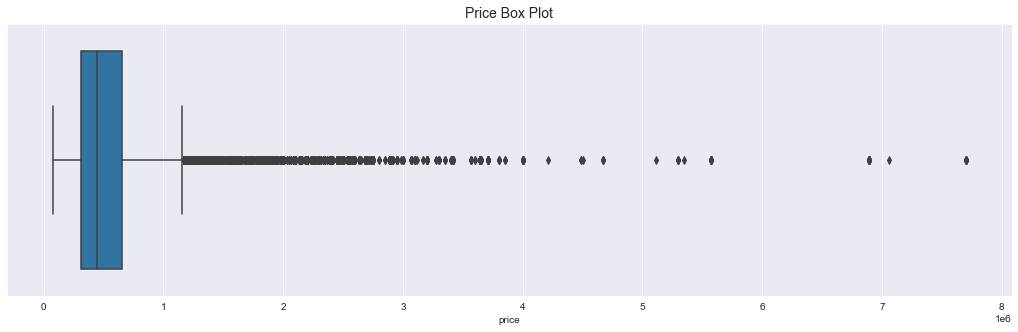

In [94]:
# Create figure
fig = plt.figure(figsize=(18,5))

# Box Plot
sns.boxplot(x=model_df['price'])
plt.title('Price Box Plot', size=14)
plt.show();

In a Box Plot, the values above the Maximum, represented by the Vertical Line on the right side of the Blue Box, are considered outliers. Here's the Maximum Amount calculation: Third Quartile + (1.5 * Interquartile Range).

As the picture above shows, there are a lot of outliers above the Maximum Amount. Let's calculate the Maximum Amount and then look at the quantiles.

In [95]:
# Calculate Third Quartile and IQR
q3, q1 = np.percentile(model_df['price'], [75, 25])
iqr = q3 - q1

# Calculate Maximum Amount
max_amount = q3 + (1.5 * iqr)
print('Maximum Amount is:', max_amount)

Maximum Amount is: 1162500.0


In [96]:
# Create Empty list to store quantiles
quantiles_lst = []

# Loop through quantiles and append to list
for i in range(1, 100):
    quantiles_lst.append([i, model_df['price'].quantile(i/100)])

# Create DataFrame
quant_df = pd.DataFrame(quantiles_lst)
quant_df.columns = ['quantile', 'value']

# Calculate Difference between quantiles
quant_df['diff'] = quant_df['value'].diff()
display(quant_df.head(10))
display(quant_df.tail(10))

quantile     value     diff
0         1  150000.0      NaN
1         2  170000.0  20000.0
2         3  187000.0  17000.0
3         4  199999.0  12999.0
4         5  207000.0   7001.0
5         6  215000.0   8000.0
6         7  222000.0   7000.0
7         8  229900.0   7900.0
8         9  235000.0   5100.0
9        10  240000.0   5000.0

quantile      value      diff
89        90   931000.0   31000.0
90        91   969969.6   38969.6
91        92  1000000.0   30030.4
92        93  1090000.0   90000.0
93        94  1190000.0  100000.0
94        95  1280000.0   90000.0
95        96  1400000.0  120000.0
96        97  1600000.0  200000.0
97        98  1850000.0  250000.0
98        99  2400000.0  550000.0

It's easier to spot the outliers on the upper side. I'm going to remove the outliers based on the Maximum Amount calculated before.

In [97]:
# Check how much of the data will be removed
print('After removing outliers, the following percentage of the original data remains: ')
model_df['price'].between(0, max_amount).sum() / len(model_df)

After removing outliers, we will have the following percentage of the original data: 


0.9382534409112482

Not too bad. <br>Somewhat of an arbitrary judgment, though. However, I'm comfortable excluding roughly 6% of the dataset. Moreover, as plotted before, these outliers on the upper side of `price` were causing most of the problems.

The trade-off is the impact on how the model will perform on predicting those extreme values.

In [98]:
# Remove Outliers
model_df = model_df[model_df['price'].between(0, max_amount)]

Rerun model to see results

In [99]:
# Rerun model without outliers
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     2661.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:39:18   Log-Likelihood:            -5.0556e+05
No. Observations:               39538   AIC:                         1.011e+06
Df Residuals:                   39459   BIC:                         1.012e+06
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -4.21e+07   1.85e+06    -22.747      0.000   -4.57e+07   -3.85e+07
bedrooms          -4625.6630    589.044     -7.853      0.000   -5780.204   -3471.123
bathrooms          7554.6316    861.688      8.767      0.000    5865.703    9243.561
sqft_living        6.058e+04   2051.646     29.527      0.000    5.66e+04    6.46e+04
sqft_lot           1.512e+04    695.387     21.738      0.000    1.38e+04    1.65e+04
waterfront         1.194e+05   8017.638     14.898      0.000    1.04e+05    1.35e+05
grade              5.489e+04    893.392     61.438      0.000    5.31e+04    5.66e+04
sqft_above         4.351e+04   2038.072     21.350      0.000    3.95e+04    4.75e+04
yr_built           2.162e+04    939.389     23.014      0.000    1.98e+04    2.35e+04
yr_renovated       2067.3304    150.452     13.741      0.000    1772.441    2362.220
long               6.857e+04   1156.326     59.301      0.000    6.63e+04    7.08e+04
sqft_living15       2.81e+04    842.213     33.367      0.000    2.65e+04    2.98e+04
sqft_lot15        -2415.1324    703.526     -3.433      0.001   -3794.060   -1036.205
downtown_distance -9.171e+04   1132.668    -80.971      0.000   -9.39e+04   -8.95e+04
has_view           6.694e+04   1698.642     39.409      0.000    6.36e+04    7.03e+04
has_basement       3447.9230   1715.906      2.009      0.045      84.706    6811.140
has_renovation    -4.086e+06      3e+05    -13.613      0.000   -4.67e+06    -3.5e+06
age                6.471e+05   2.77e+04     23.402      0.000    5.93e+05    7.01e+05
zipcode_98003     -4443.6682   4088.126     -1.087      0.277   -1.25e+04    3569.157
zipcode_98004      2.877e+05   5117.704     56.222      0.000    2.78e+05    2.98e+05
zipcode_98005      9.985e+04   3948.065     25.290      0.000    9.21e+04    1.08e+05
zipcode_98007      3.495e+04   3817.415      9.155      0.000    2.75e+04    4.24e+04
zipcode_98010      5912.9252   3815.284      1.550      0.121   -1565.123    1.34e+04
zipcode_98014     -5.195e+04   4076.578    -12.745      0.000   -5.99e+04    -4.4e+04
zipcode_98019     -6.278e+04   3834.912    -16.372      0.000   -7.03e+04   -5.53e+04
zipcode_98023      9634.0387   4319.346      2.230      0.026    1168.016    1.81e+04
zipcode_98027      3784.9828   3825.274      0.989      0.322   -3712.647    1.13e+04
zipcode_98029      3.455e+04   3877.137      8.911      0.000    2.69e+04    4.21e+04
zipcode_98030     -8.131e+04   3705.853    -21.942      0.000   -8.86e+04   -7.41e+04
zipcode_98031     -1.047e+05   3659.054    -28.624      0.000   -1.12e+05   -9.76e+04
zipcode_98032     -6.701e+04   3790.706    -17.677      0.000   -7.44e+04   -5.96e+04
zipcode_98033      1.175e+05   3963.047     29.651      0.000     1.1e+05    1.25e+05
zipcode_98038     -6.824e+04   3760.947    -18.144      0.000   -7.56e+04

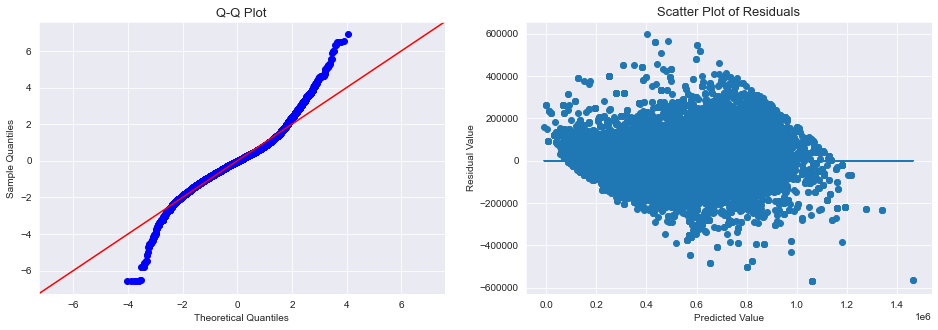

In [100]:
model_evaluation(model, model_df)

#### Observations:
- Increased R-Squared to 0.84 and decreased JB considerably.
- Plots look much better, still not perfect, but I'm happy with them.

Let's calculate the metrics using cross-validation.

In [101]:
# Create X and y
X = model_df[x_cols]
y = model_df['price']

# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X, y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['remove_outliers', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8392888823303203
Neg Mean Squared Error: -7519587619.335353


It has considerably reduced MSE as well.

**[Go back to Table of Contents](#toc)**

### Remove features where p-value > 0.05 (again) <a class="anchor" id="model_4"></a>
I still noticed a few features where the p-value is above 0.05, so I will remove those.

In [102]:
# Remove features which do not appear to be statistically relevant
to_exclude = list(model.pvalues[model.pvalues > 0.05].index)

# Remove Columns
for col in x_cols:
    if col in to_exclude:
        x_cols.remove(col)
predictors = '+'.join(x_cols)

# Your code here - Refit the model
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     2923.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:39:25   Log-Likelihood:            -5.0556e+05
No. Observations:               39538   AIC:                         1.011e+06
Df Residuals:                   39466   BIC:                         1.012e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -4.213e+07   1.85e+06    -22.773      0.000   -4.58e+07   -3.85e+07
bedrooms          -4557.8082    585.952     -7.778      0.000   -5706.288   -3409.328
bathrooms          7536.2245    859.784      8.765      0.000    5851.027    9221.422
sqft_living        6.026e+04   2042.095     29.509      0.000    5.63e+04    6.43e+04
sqft_lot           1.512e+04    695.219     21.755      0.000    1.38e+04    1.65e+04
waterfront         1.197e+05   8010.958     14.942      0.000    1.04e+05    1.35e+05
grade              5.489e+04    890.464     61.638      0.000    5.31e+04    5.66e+04
sqft_above         4.411e+04   2011.160     21.931      0.000    4.02e+04     4.8e+04
yr_built           2.164e+04    939.052     23.042      0.000    1.98e+04    2.35e+04
yr_renovated       2067.0858    150.273     13.756      0.000    1772.548    2361.624
long               6.957e+04    986.002     70.553      0.000    6.76e+04    7.15e+04
sqft_living15       2.81e+04    835.894     33.622      0.000    2.65e+04    2.97e+04
sqft_lot15        -2323.2929    702.593     -3.307      0.001   -3700.391    -946.194
downtown_distance -9.243e+04    959.244    -96.360      0.000   -9.43e+04   -9.06e+04
has_view           6.677e+04   1690.846     39.489      0.000    6.35e+04    7.01e+04
has_basement       3556.6035   1714.581      2.074      0.038     195.983    6917.224
has_renovation    -4.085e+06      3e+05    -13.628      0.000   -4.67e+06    -3.5e+06
age                6.479e+05   2.76e+04     23.438      0.000    5.94e+05    7.02e+05
zipcode_98004      2.862e+05   5073.735     56.410      0.000    2.76e+05    2.96e+05
zipcode_98005      9.824e+04   3891.296     25.246      0.000    9.06e+04    1.06e+05
zipcode_98007      3.331e+04   3760.593      8.858      0.000    2.59e+04    4.07e+04
zipcode_98014     -5.375e+04   3982.169    -13.497      0.000   -6.16e+04   -4.59e+04
zipcode_98019     -6.426e+04   3771.922    -17.036      0.000   -7.16e+04   -5.69e+04
zipcode_98023      1.079e+04   4088.292      2.640      0.008    2779.757    1.88e+04
zipcode_98029      3.302e+04   3812.547      8.661      0.000    2.55e+04    4.05e+04
zipcode_98030      -8.15e+04   3658.409    -22.276      0.000   -8.87e+04   -7.43e+04
zipcode_98031     -1.052e+05   3628.804    -28.992      0.000   -1.12e+05   -9.81e+04
zipcode_98032     -6.671e+04   3715.773    -17.952      0.000    -7.4e+04   -5.94e+04
zipcode_98033      1.163e+05   3923.509     29.633      0.000    1.09e+05    1.24e+05
zipcode_98038     -6.904e+04   3714.710    -18.587      0.000   -7.63e+04   -6.18e+04
zipcode_98039      3.969e+05   9472.178     41.905      0.000    3.78e+05    4.15e+05
zipcode_98040      1.882e+05   4818.814     39.061      0.000    1.79e+05    1.98e+05
zipcode_98042     -9.076e+04   3656.243    -24.824      0.000   -9.79e+04

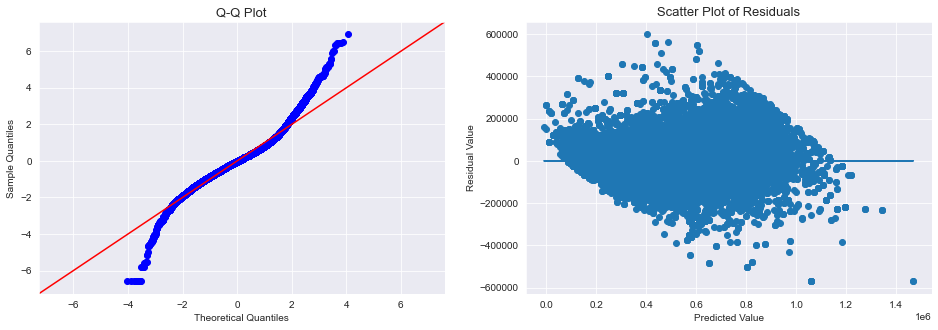

In [103]:
model_evaluation(model, model_df)

#### Observations:
- Removed seven features
- Kept the same R-Squared and JB

Run the same model on cross-validation.

In [104]:
# Create X and y
X = model_df[x_cols]
y = model_df['price']

# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X, y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['second_remove_p_values', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8393037716632852
Neg Mean Squared Error: -7518900578.868543


**[Go back to Table of Contents](#toc)**

### Investigate Multicolinearity <a class="anchor" id="model_5"></a>
There are still too many variables (**71**). Probably there is some Multicolinerarity that I can fix.

To identify Multicolinerarity between variables, I will calculate the Variance Inflation Factor and see which ones are above 5.

In [105]:
# Calculate vif
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = pd.DataFrame(list(zip(x_cols, vif)))
vif_df.columns = ['variable', 'vif']
vif_df[vif_df['vif'] > 5]

variable           vif
2      sqft_living  1.496082e+01
6       sqft_above  1.560385e+01
7         yr_built  9.947342e+00
8     yr_renovated  1.534439e+04
9             long  5.297234e+00
13        has_view           inf
14    has_basement  5.717662e+00
15  has_renovation  1.534346e+04
66  view_1_point_0           inf
67  view_2_point_0           inf
68  view_3_point_0           inf
69  view_4_point_0           inf

Some of the variables have the same meaning. For example, `sqft_living` and `sqft_above` will most of the time be pretty similar unless the house has a different structure/footage on different floors. `yr_renovated` and `has_renovation` are also identical.

Therefore, I'm going to look at the correlations with `price` to decide which ones to remove and then rerun VIF.

In [106]:
# Create list with variables
vif_cols = vif_df[vif_df['vif'] > 5]['variable'].to_list()
vif_cols.append('price')

# Calculate Correlations
model_df[vif_cols].corr()[['price']].sort_values('price', ascending=False)

price
price           1.000000
sqft_living     0.621303
sqft_above      0.533062
has_view        0.230525
has_basement    0.170928
view_2_point_0  0.151831
view_4_point_0  0.116985
view_3_point_0  0.102977
yr_renovated    0.082592
has_renovation  0.082227
view_1_point_0  0.072401
yr_built        0.052422
long            0.041244

- Keeping `sqft_living` because it has a higher correlation than `sqft_above`.
- Keeping the boolean `has_view` and removing dummies on view.
- Keeping `has_renovation` because it has a very similar correlation to `yr_renovated`. However, since it's a binary variable, it carries a lower computational cost.
- Removing `yr_built` and `long` due to really low correlation
- I'm not removing `has_basement` because I don't see any other variable that would bring the same information. 

In [107]:
# Create list of columns to be removed
cols_to_remove = ['sqft_above', 'view_1_point_0', 'view_2_point_0', 'view_3_point_0', 'view_4_point_0', 
                  'yr_built', 'yr_renovated', 'long']

After removing the variables, I'm going to rerun the same analysis, and check results.

In [108]:
# Remove columns from x_cols
for col in cols_to_remove:
    x_cols.remove(col)

# Define X
X = model_df[x_cols]

# Calculate vif
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = pd.DataFrame(list(zip(x_cols, vif)))
vif_df.columns = ['variable', 'vif']
vif_df[vif_df['vif'] > 5]

Empty DataFrame
Columns: [variable, vif]
Index: []

Nice. Let's rerun the model.

In [109]:
# Rerun the model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     2699.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:40:10   Log-Likelihood:            -5.0857e+05
No. Observations:               39538   AIC:                         1.017e+06
Df Residuals:                   39473   BIC:                         1.018e+06
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.035e+05   1440.244    349.574      0.000    5.01e+05    5.06e+05
bedrooms          -6214.4664    631.532     -9.840      0.000   -7452.284   -4976.648
bathrooms          8611.6545    926.549      9.294      0.000    6795.596    1.04e+04
sqft_living        9.675e+04   1257.014     76.967      0.000    9.43e+04    9.92e+04
sqft_lot           1.707e+04    749.125     22.789      0.000    1.56e+04    1.85e+04
waterfront         1.781e+05   7864.213     22.643      0.000    1.63e+05    1.93e+05
grade              5.938e+04    947.964     62.640      0.000    5.75e+04    6.12e+04
sqft_living15      3.598e+04    890.807     40.385      0.000    3.42e+04    3.77e+04
sqft_lot15          552.7747    756.704      0.731      0.465    -930.384    2035.933
downtown_distance -4.563e+04    758.110    -60.188      0.000   -4.71e+04   -4.41e+04
has_view           5.207e+04   1858.330     28.021      0.000    4.84e+04    5.57e+04
has_basement      -2.569e+04   1191.929    -21.557      0.000    -2.8e+04   -2.34e+04
has_renovation     3.497e+04   2822.493     12.391      0.000    2.94e+04    4.05e+04
age                1.129e+04    836.303     13.503      0.000    9653.622    1.29e+04
zipcode_98004      3.211e+05   5441.066     59.022      0.000     3.1e+05    3.32e+05
zipcode_98005      1.363e+05   4152.137     32.833      0.000    1.28e+05    1.44e+05
zipcode_98007       7.89e+04   3987.936     19.785      0.000    7.11e+04    8.67e+04
zipcode_98014      2.553e+04   4108.746      6.213      0.000    1.75e+04    3.36e+04
zipcode_98019     -6319.3268   3967.738     -1.593      0.111   -1.41e+04    1457.535
zipcode_98023     -1.168e+05   3962.335    -29.469      0.000   -1.25e+05   -1.09e+05
zipcode_98029      9.357e+04   3987.837     23.464      0.000    8.58e+04    1.01e+05
zipcode_98030     -1.097e+05   3921.300    -27.972      0.000   -1.17e+05   -1.02e+05
zipcode_98031     -1.194e+05   3908.782    -30.544      0.000   -1.27e+05   -1.12e+05
zipcode_98032     -1.238e+05   3916.027    -31.612      0.000   -1.31e+05   -1.16e+05
zipcode_98033      1.466e+05   4206.206     34.842      0.000    1.38e+05    1.55e+05
zipcode_98038     -5.506e+04   3999.903    -13.766      0.000   -6.29e+04   -4.72e+04
zipcode_98039      4.186e+05   1.02e+04     41.078      0.000    3.99e+05    4.39e+05
zipcode_98040      2.112e+05   5177.924     40.791      0.000    2.01e+05    2.21e+05
zipcode_98042     -9.669e+04   3942.369    -24.525      0.000   -1.04e+05    -8.9e+04
zipcode_98052      9.276e+04   3959.809     23.426      0.000     8.5e+04    1.01e+05
zipcode_98055     -1.036e+05   3901.817    -26.543      0.000   -1.11e+05   -9.59e+04
zipcode_98056     -6.204e+04   3950.745    -15.704      0.000   -6.98e+04   -5.43e+04
zipcode_98058     -1.025e+05   3903.306    -26.257      0.000    -1.1e+05

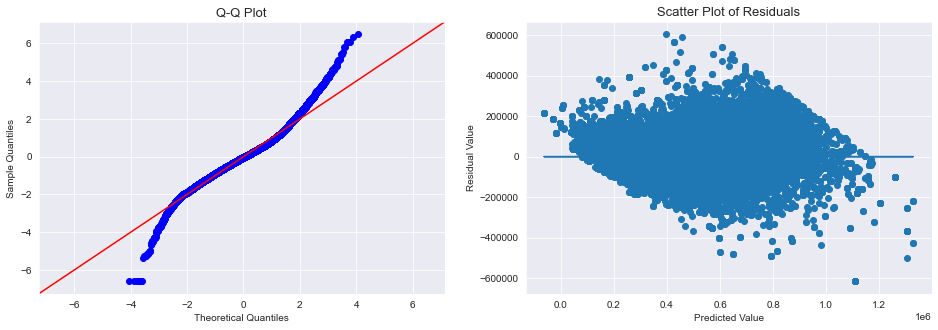

In [110]:
model_evaluation(model, model_df)

#### Observations:
- Removed seven variables
- R-squared reduced a bit, but it's expected since we're dealing with a Linear Regression model (fewer variables most of the time will reduce accuracy)
- Charts look similar

Run model on cross-validation

In [111]:
# Create X and y
X = model_df[x_cols]
y = model_df['price']

# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X, y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['multicollinearity', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8131090896258586
Neg Mean Squared Error: -8744781663.772509


**[Go back to Table of Contents](#toc)**

### Remove features where p-value > 0.05 (again) <a class="anchor" id="model_6"></a>

In [112]:
# Remove features which do not appear to be statistically relevant
to_exclude = list(model.pvalues[model.pvalues > 0.05].index)

# Remove Columns
for col in x_cols:
    if col in to_exclude:
        x_cols.remove(col)
predictors = '+'.join(x_cols)

# Your code here - Refit the model
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     2831.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:40:16   Log-Likelihood:            -5.0857e+05
No. Observations:               39538   AIC:                         1.017e+06
Df Residuals:                   39476   BIC:                         1.018e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.035e+05   1430.017    352.117      0.000    5.01e+05    5.06e+05
bedrooms          -6256.9338    630.216     -9.928      0.000   -7492.173   -5021.695
bathrooms          8595.1581    926.388      9.278      0.000    6779.415    1.04e+04
sqft_living         9.68e+04   1255.403     77.103      0.000    9.43e+04    9.93e+04
sqft_lot           1.742e+04    555.392     31.370      0.000    1.63e+04    1.85e+04
waterfront         1.779e+05   7862.515     22.620      0.000    1.62e+05    1.93e+05
grade              5.949e+04    945.565     62.917      0.000    5.76e+04    6.13e+04
sqft_living15      3.591e+04    884.081     40.614      0.000    3.42e+04    3.76e+04
downtown_distance -4.587e+04    732.615    -62.610      0.000   -4.73e+04   -4.44e+04
has_view           5.222e+04   1853.162     28.178      0.000    4.86e+04    5.59e+04
has_basement      -2.567e+04   1191.754    -21.541      0.000    -2.8e+04   -2.33e+04
has_renovation     3.497e+04   2822.421     12.390      0.000    2.94e+04    4.05e+04
age                1.137e+04    834.935     13.620      0.000    9735.105     1.3e+04
zipcode_98004      3.209e+05   5434.014     59.056      0.000     3.1e+05    3.32e+05
zipcode_98005      1.362e+05   4146.131     32.845      0.000    1.28e+05    1.44e+05
zipcode_98007      7.876e+04   3980.692     19.786      0.000     7.1e+04    8.66e+04
zipcode_98014      2.635e+04   4076.801      6.463      0.000    1.84e+04    3.43e+04
zipcode_98023     -1.165e+05   3952.824    -29.468      0.000   -1.24e+05   -1.09e+05
zipcode_98029      9.374e+04   3978.432     23.563      0.000    8.59e+04    1.02e+05
zipcode_98030     -1.095e+05   3912.258    -27.979      0.000   -1.17e+05   -1.02e+05
zipcode_98031     -1.193e+05   3901.328    -30.568      0.000   -1.27e+05   -1.12e+05
zipcode_98032     -1.237e+05   3910.584    -31.634      0.000   -1.31e+05   -1.16e+05
zipcode_98033      1.464e+05   4197.791     34.881      0.000    1.38e+05    1.55e+05
zipcode_98038     -5.456e+04   3985.401    -13.691      0.000   -6.24e+04   -4.68e+04
zipcode_98039      4.183e+05   1.02e+04     41.067      0.000    3.98e+05    4.38e+05
zipcode_98040      2.109e+05   5170.944     40.791      0.000    2.01e+05    2.21e+05
zipcode_98042     -9.636e+04   3932.694    -24.502      0.000   -1.04e+05   -8.87e+04
zipcode_98052      9.277e+04   3953.606     23.464      0.000     8.5e+04    1.01e+05
zipcode_98055     -1.036e+05   3893.013    -26.614      0.000   -1.11e+05    -9.6e+04
zipcode_98056     -6.214e+04   3941.537    -15.766      0.000   -6.99e+04   -5.44e+04
zipcode_98058     -1.024e+05   3897.250    -26.276      0.000    -1.1e+05   -9.48e+04
zipcode_98059     -5.542e+04   3988.902    -13.894      0.000   -6.32e+04   -4.76e+04
zipcode_98065      3.571e+04   4050.714      8.815      0.000    2.78e+04

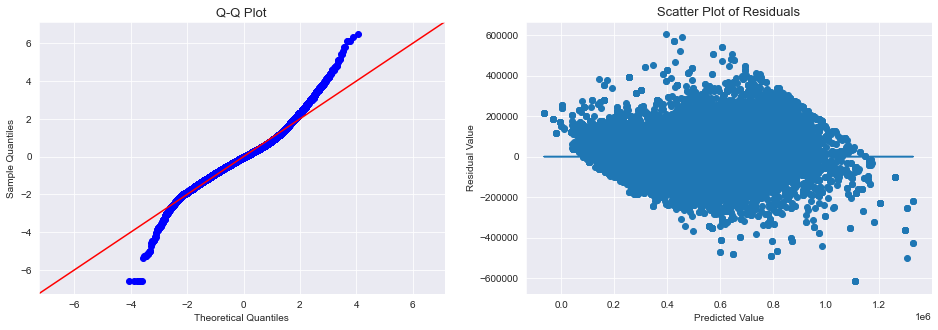

In [113]:
model_evaluation(model, model_df)

#### Observations:
- Removed three variables.
- No change in R-Squared.

Run new model on cross-validation


In [114]:
# Create X and y
X = model_df[x_cols]
y = model_df['price']

# Instantiate model and cross validation
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# Calculate Baseline R Squared and Negative Mean Squared Error
r_squared = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
neg_mse = np.mean(cross_val_score(regression, X, y, scoring='neg_mean_squared_error', cv=crossvalidation))

# No. of Features
no_of_features = len(x_cols)

# Store results and print
models_performance.append(['third_remove_p_values', r_squared, neg_mse, no_of_features])
print('R-Squared:', r_squared)
print('Neg Mean Squared Error:', neg_mse)

R-Squared: 0.8131416845883649
Neg Mean Squared Error: -8743253542.503086


**[Go back to Table of Contents](#toc)**

## Model Analysis <a class="anchor" id="model_an"></a>
As I went through all steps, I recorded a few metrics to see how the model improved.

In [115]:
# Convert to DataFrame
perf_df = pd.DataFrame(models_performance)
perf_df.columns = ['approach', 'r_squared', 'neg_mse', 'no_of_features']
perf_df

approach  r_squared       neg_mse  no_of_features
0                baseline   0.822439 -3.452087e+10             100
1   first_remove_p_values   0.821661 -3.467049e+10              79
2         remove_outliers   0.839289 -7.519588e+09              79
3  second_remove_p_values   0.839304 -7.518901e+09              72
4       multicollinearity   0.813109 -8.744782e+09              64
5   third_remove_p_values   0.813142 -8.743254e+09              61

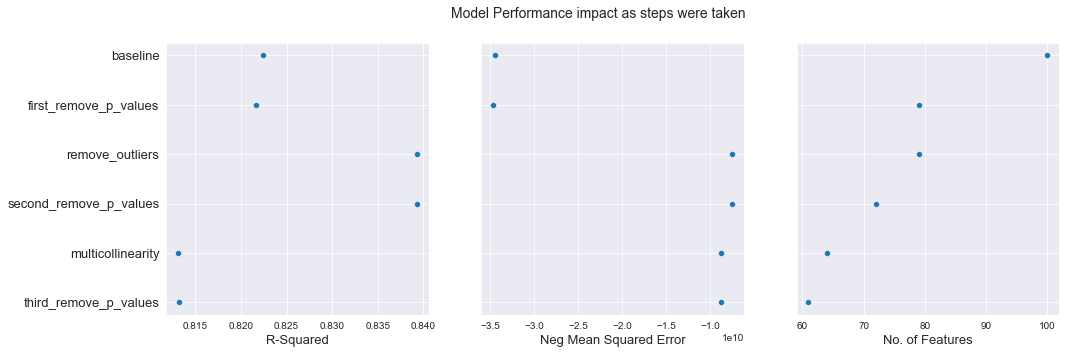

In [116]:
# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

# Add Title to Figure
fig.suptitle("Model Performance impact as steps were taken", fontsize=14)

# R-Squared
sns.scatterplot(data=perf_df, y="approach", x="r_squared", ax=ax1)
ax1.set_yticklabels(perf_df['approach'], size=13)
ax1.set_ylabel(None)
ax1.set_xlabel('R-Squared', size=13)

# Neg Mean Squared Error
sns.scatterplot(data=perf_df, y="approach", x="neg_mse", ax=ax2)
ax2.set_yticklabels([None])
ax2.set_ylabel(None)
ax2.set_xlabel('Neg Mean Squared Error', size=13)

# Homoscedasticity
sns.scatterplot(data=perf_df, y="approach", x="no_of_features", ax=ax3)
ax3.set_yticklabels([None])
ax3.set_ylabel(None)
ax3.set_xlabel('No. of Features', size=13)

plt.show();

#### Conclusions:
- It's interesting to see that R-Squared increased when outliers were removed but reduced as I removed variables with multicollinearity. That's expected, though, since in regression models, removing variables means that the model doesn't have all data available to predict the target. On the other hand, eliminating outliers tends to increase accuracy because removing those edge cases makes it hard for a model to predict.
- Looking at Mean Squared Error, though, it's satisfactory to see how the metric reduced by ~72% after removing outliers and was kept around the same after solving multicollinearity and removing ten extra features from the model.
- The final model has 61 features, which is a nice drop from the initial 100.

I could have taken more steps to increase accuracy at the cost of losing interpretability. However, since I'm trying to create a model to understand Seattle's Real Estate market in this exercise, I'm happy with the result.

**[Go back to Table of Contents](#toc)**

## Model Interpretation <a class="anchor" id="model_in"></a>
One of the benefits of utilizing Linear Regression is the interpretability of the coefficients. By comparing them, I can tell the impact of a given variable on the variable I'm trying to predict.

In [117]:
# Extract Coefficient weights from model
coef_df = pd.DataFrame(model.params).reset_index()
coef_df.columns = ['variable', 'coef']
coef_df = coef_df.sort_values('coef')
coef_df['color'] = 'sandybrown'
coef_df.loc[coef_df['variable'].str.contains('zipcode') == True, 'color'] = 'coral'

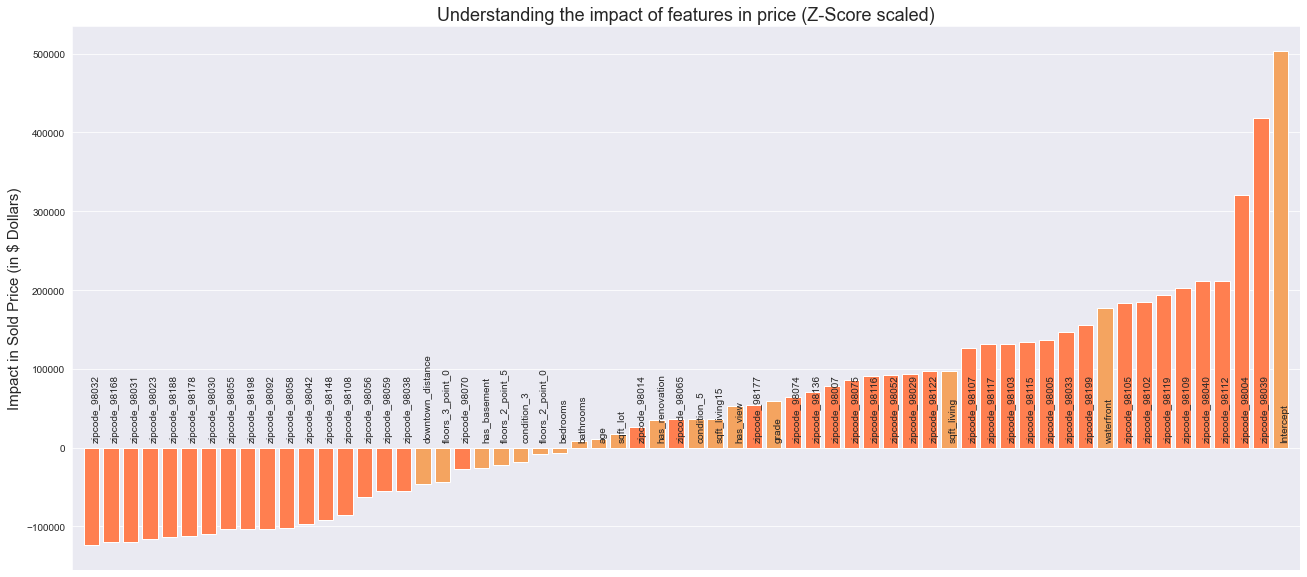

In [118]:
# Create figure
fig = plt.figure(figsize=(22,10))

# Plot Bar Chart
plt.bar(x=coef_df['variable'], height=coef_df['coef'], align='center', color=coef_df['color'])
plt.xlim([-1, len(coef_df['coef'])])
plt.xticks([])
plt.ylabel('Impact in Sold Price (in $ Dollars)', rotation=90, size=15)

# Add text with variable names
for row in coef_df.iterrows():
    
    # Define Variable
    variable = row[1]['variable']
    plt.text(variable, 10000, variable, size=10, rotation=90)

# Title
plt.title('Understanding the impact of features in price (Z-Score scaled)', size=18)
plt.show();

### The importance of Zip Code
By looking at the chart above, it's easy to see the relevance of some Zip Codes. Most of the highest/lowest coefficients are Zip Codes. Moreover, after taking all steps to optimize the model, 26 of them were removed. 

What does that mean? It means that for these 26, only with the `Intercept` and other features, the model can predict `price`.

To compare Zip Codes, I'm going to remove all other features and plot the coefficients.

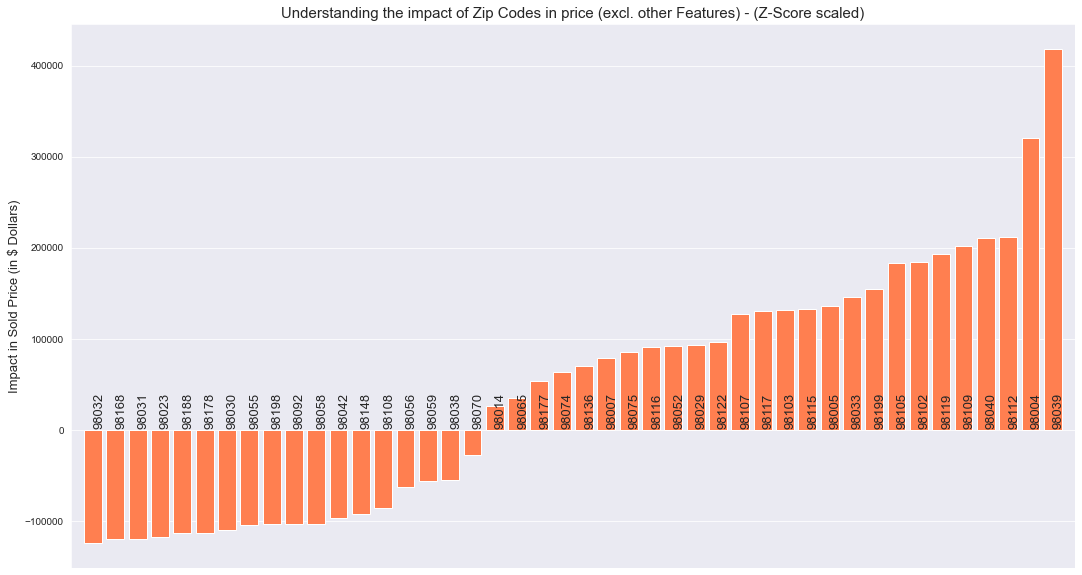

In [119]:
# Create figure
fig = plt.figure(figsize=(18,10))

# Temporary dataframe to plot
to_plot = coef_df[coef_df['variable'].str.contains('zipcode') == True]
to_plot = to_plot.reset_index(drop=True)

# Plot Bar Chart
plt.bar(x=to_plot['variable'], height=to_plot['coef'], align='center', color=to_plot['color'])
plt.xlim([-1, len(to_plot['coef'])])
plt.xticks([])
plt.ylabel('Impact in Sold Price (in $ Dollars)', rotation=90, size=13)

# Add text with variable names
for row in to_plot.iterrows():

    # Define Variable, Coefficient and Index
    variable = row[1]['variable']
    
    # Plot text
    plt.text(variable, 5000, variable[8:], size=13, rotation=90)

# Title
plt.title('Understanding the impact of Zip Codes in price (excl. other Features) - (Z-Score scaled)', size=15)
plt.show();

To highlight a few of them:
- `98039 and 98004` are the Zip Codes that add more value to `price`.
- `98032 and 98168` are the ones that reduce the most value from `price`; however, most of them have around the same impact.

### Removing Zip Codes
There are other important features on the model as well. To see that, I'll remove Zip Codes from the chart.

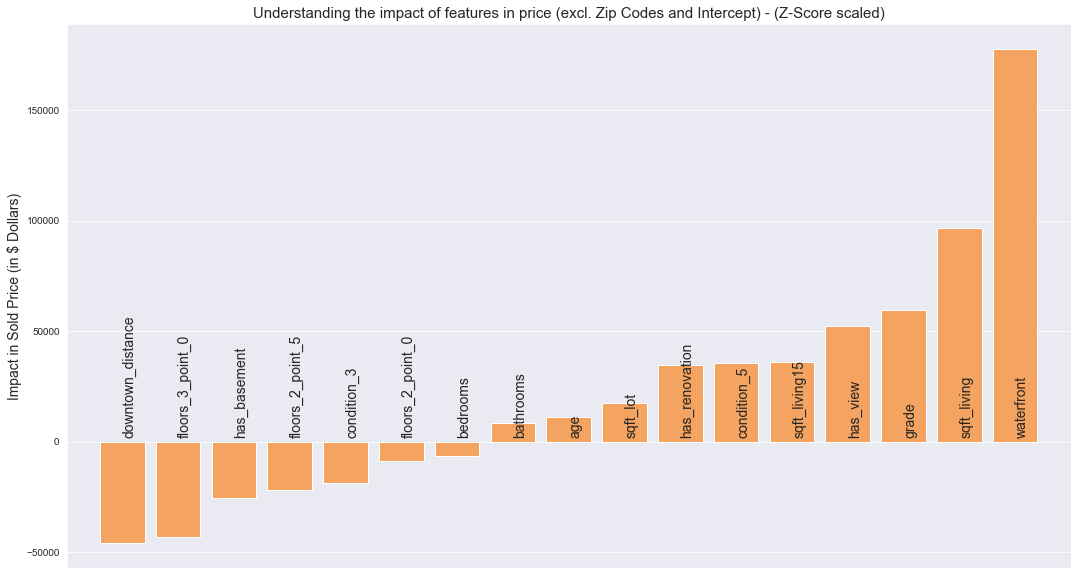

In [120]:
# Create figure
fig = plt.figure(figsize=(18,10))

# Temporary dataframe to plot
to_plot = coef_df[coef_df['variable'].str.contains('zipcode') == False]
to_plot = to_plot[to_plot['variable'].str.contains('Intercept') == False]
to_plot = to_plot.reset_index(drop=True)

# Plot Bar Chart
plt.bar(x=to_plot['variable'], height=to_plot['coef'], align='center', color=to_plot['color'])
plt.xlim([-1, len(to_plot['coef'])])
plt.xticks([])
plt.ylabel('Impact in Sold Price (in $ Dollars)', rotation=90, size=14)

# Add text with variable names
for row in to_plot.iterrows():

    # Define Variable, Coefficient and Index
    variable = row[1]['variable']
    
    # Plot text
    plt.text(variable, 3000, variable, size=14, rotation=90)

# Title
plt.title('Understanding the impact of features in price (excl. Zip Codes and Intercept) - (Z-Score scaled)', size=15)
plt.show();

### Impact of House Features
- Increase House Value: `waterfront`, `sqft_living`, `grade` and `has_view`.
- Decrease House Value: `downtown_distance`, `floors_3_point_0`, `has_basement` and `condition_3`.

`waterfront` (field definition: `House which has a view to a waterfront`) is the most relevant feature. This confirms what I've seen on the maps before: Houses near Lake Washington's shoreline have higher prices.

### Analysis of continuous features in a regular scale
Although it's relevant to compare features on the same scale (Z-Score), I think it's important for stakeholders to see the change in `price` given a marginal addition/reduction of one unit of a continuous feature. For example, how much price increases if `sqft_living` goes up by one? It's hard to answer that by looking at the current coefficients since they were calculated on a different scale (Z-Score).

#### Create Function to quickly show coefficient on the regular scale

In [121]:
def features_model_impact(coef_df, model_df_pre_norm, column_names):
    """
    This function take a DataFrame with Feature Coefficients in Normalized Scale (Z-Score) and convert
    it to it's original scale, so it's easier to understand the impact of the feature.
    
    Calculation:
        If model has coefficients in Z-Score, then the first step to convert it to the feature's scale
        is to calculate how much a Z-Score of 1 represents.
    
        If Z-Score's formula is: 
            Z-Score = (Column Value - Column Mean) / Column Standard Deviation
        
        Then, when Z-Score = 1:
            (1 * Column Standard Deviation) = Column Value - Column Mean
            Column Value = Column Standard Deviation + Column Mean
            
        Finally, Feature's Coefficient in its original scale is:
            Z-Score Coefficient / Feature's Value of one Z-Score
            
    Args:
      coef_df(pandas.DataFrame): DataFrame with Variables and Coefficients in Z-Score.
      model_df_pre_norm(pandas.DataFrame): DataFrame with raw data, pre-normalization.
      column_names(list): List of continuous variables to be analyzed.

    Returns:
        A Pandas DataFrame with Feature Names, One Z-Score Value in Feature's Scale and 
        Feature Coefficient in regular scale.
    """
    # Empty list to store results
    results = []
    
    # Loop through columns
    for column in column_names:
        
        # Extract Coefficient Value
        coef_value = coef_df[coef_df['variable'] == column]['coef'].values[0]
        
        # Calculate Mean and Standard Deviation from original dataset
        col_mean = np.mean(model_df_pre_norm[column])
        col_std = np.std(model_df_pre_norm[column])
        
        # Calculate how much one Z-Score represents in column's scale
        col_one_z_score = col_mean + col_std
        
        # Calculate Feature Coefficient in column's scale
        col_coef_regular_scale = round(coef_value / col_one_z_score, 0)
        
        # Append number
        results.append([column, col_coef_regular_scale, col_one_z_score])
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df.columns = ['feature_(1)', 'marginal_price_change_regular_scale_(2)', 'one_z_score_value_(3)']
    
    return results_df

In [122]:
# Model columns - Extract Column Names from final model
model_columns = coef_df[coef_df['variable'].str.contains('zipcode') == False]['variable'].to_list()

# See overlap between Continous Columns List and Model Columns
model_continous_cols = list(set(continuous_cols) & set(model_columns))

# Analyze 'sqft_living', 'grade' and 'downtown_distance'
continuous_feat_df = features_model_impact(coef_df, model_df_pre_norm, model_continous_cols)
continuous_feat_df[['feature_(1)', 'marginal_price_change_regular_scale_(2)']].sort_values('feature_(1)')

feature_(1)  marginal_price_change_regular_scale_(2)
0                age                                    154.0
3          bathrooms                                   2945.0
5           bedrooms                                  -1456.0
1  downtown_distance                                  -1520.0
2              grade                                   6706.0
4        sqft_living                                     32.0
6      sqft_living15                                     13.0
7           sqft_lot                                      0.0

#### Interpretation:
One unit up in the following features will have an impact of ($) in `price`:
- `grade`: As grade goes up one score, `price` goes up by +6,706 USD.
- `bathrooms`: As the No. of Bathrooms goes up by one, `price` goes up by +2,945 USD.
- `bedrooms`: As the No. of Bedrooms goes up by one, `price` goes down by -1,456 USD.
- `downtown_distance`: As the Distance from Downtown Seattle goes up by 1km, `price` goes down by -1,520 USD.
- `age`: As the House's age goes up by one year, `price` goes up by +154 USD.
- `sqft_living15`: As the Square Footage of interior housing living space for the nearest 15 neighbors goes up by one, `price` goes up by +13 USD.
- `sqft_living`: As the House's Square Footage goes up by one, `price` goes up by +32 USD.
- `sqft_lot`: 0.00 USD >> It makes me wonder whether I should remove it from the model.

### Analysis of boolean features - Excluding Zip Codes

In [123]:
# Define Boolean Columns
boolean_cols = list(set(model_columns) - set(model_continous_cols))
boolean_cols.remove('Intercept')

# Filter coef_df and Rename Columns
binary_feat_df = coef_df[coef_df['variable'].isin(boolean_cols)][['variable', 'coef']]
binary_feat_df.columns = ['feature_(1)', 'marginal_price_change_(2)']
binary_feat_df.round(0).sort_values('feature_(1)')

feature_(1)  marginal_price_change_(2)
60       condition_3                   -18671.0
61       condition_5                    35816.0
57  floors_2_point_0                    -8505.0
58  floors_2_point_5                   -21654.0
59  floors_3_point_0                   -43279.0
10      has_basement                   -25671.0
11    has_renovation                    34971.0
9           has_view                    52219.0
5         waterfront                   177850.0

#### Interpretation:
- `floors_3_point_0`: If a house has three floors, `price` goes down by -43,279 USD.
- `has_basement`: If a house has a basement, `price` goes down by -25,671 USD.
- `floors_2_point_5`: If a house has two and a half floors, `price` goes down by -21,654 USD.
- `condition_3`: If a house's condition is three, `price` goes down by -18,671 USD.
- `floors_2_point_0`: If a house has two floors, `price` goes down by -8,504 USD.
- `has_renovation`: If house was renovated, `price` goes up by +34,970 USD.
- `condition_5`: If a house's condition score is five, `price` goes up by +35,816 USD.
- `has_view`: If a house has a view, `price` goes up by +52,219 USD.
- `waterfront`: If a house has a waterfront view, `price` goes up by +177,850 USD.

### Intercept
The model has a high **Intercept Value** relative to other coefficients' weight, which means that if all variables are zero, the house's price will be the **Intercept Value**. However, it's hard to get to such a conclusion because that would not make sense. 
>_How would a house have zero Square Footage? And no Bathrooms/Bedrooms/Grade/Downtown Distance? All at the same time?_ 

It seems a bit unrealistic to get to such a conclusion.

Nonetheless, it represents the starting point of `price` for all houses in the dataset. Then, as features are added, `price` will go up or down.

### I could remove some features
Based on the **Coefficient Value** of some features, such as `bathrooms`/`bedrooms`, maybe they are not adding a lot to `price`. Moreover, after transforming the Coefficients to the original scale of the variable, I found that `sqft_lot` is not adding a lot.

**[Go back to Table of Contents](#toc)**

# Conclusion <a class="anchor" id="conc"></a>
**1. Relative Healthy Market:** Based on the growing number of Newer Sold Houses, it's possible to say that people are investing in the Real Estate Market. If there was no interest in the area, the data would show old sold houses. The Average is 1970, and it's possible to see an upward trend. Probably there are healthier markets out there, but I'd have to compare Seattle with other places.

**2. Houses near Downtown Seattle and Washington Lake have higher prices:** Based on the `price` of sold houses and the coordinates, it's straightforward to see which areas are the most expensive. It might be of interest of the Agency to focus on luxury/expensive houses, so it's useful information.

**3. Zip Code is the most impactful feature:** After analyzing all features, the conclusion is that Zip Code has a significant impact on the `price`. Therefore, for an Agency, a good strategy could be to define the market they will operate based on the Zip Code.

**4. Other than Zip Code, Waterfront and Square Footage add more value to a house:** `Waterfront` is the most price-relevant feature after Zip Code. Houses with a Waterfront adds 177,850 dollars to the price. In second place comes the Square Footage, with 32 dollars added per unit.

**5. Distance from Downtown Seattle and Three Floors reduce more value:** On the other end of the spectrum, the farthest a house is from Downtown Seattle, the lower its price will be. More specifically, 1,520 dollars per kilometer. Moreover, interestingly, houses with Three Floors have their price reduced by 43,279 dollars.

**6. After running simulations on different Numbers of Agents and Combinations of Zip Codes, the most profitable solution was 25 Agents selling 98004 Houses:** Given the business model and some assumptions, I found the best combination of Zip Codes and No. of Agents. Moreover, by analyzing each Zip Code on each pair, I was able to find the most profitable ones: 98004, 98040, 98112, 98039, and 98006. The best part about the simulation is that it takes business inputs/constraints to calculate the most profitable option.

**7. Rethink the Business Model:** After running the simulations, I realized that Return on Investment was pretty low relative to the risk that investors were taking. Therefore, another suggestion would be to rethink the business model and optimize it.

**[Go back to Table of Contents](#toc)**

# Next Steps <a class="anchor" id="next_steps"></a>
**The Simulation Machine:** Given the results achieved after running simulations, one of my concerns was that my assumptions were entirely wrong or the business model doesn't make sense. However, the exercise of creating this 'simulation machine' is the main goal here. The idea is to show how to take a data-driven approach to make strategic decisions. Ideally, I'd work directly with stakeholders to make sure that assumptions are realistic, and I'm taking into consideration all inputs in my model. Besides that, I'd like to test different scenarios. As I said before, it's hard to analyze something without business understanding. Maybe the strategy focuses on Luxury houses, or maybe there's a funding limit, or perhaps the business-owner already has a team with X No. of Agents. Without that information, the model becomes too generalistic and maybe not realistic.

**Gather more data on houses that were not sold:** The dataset is heavily skewed towards successful sold homes cases. I'd also like to understand if there's some pattern in houses that did not sell. Maybe certain features make it harder to sell a house.

**Create different models for each Zip Code:** To achieve higher accuracy, a good idea would be to create one model for each Zip Code. That would bring a more granular understanding of the most/least valuable features within Zip Codes.

**[Go back to Table of Contents](#toc)**